In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
import re

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [2]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [3]:
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [4]:
env.render()

|- - -|
|- - -|
|- - -|



In [5]:
env.observe()

(array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 False,
 None)

### Test

In [6]:
Turns = np.array(['X','O'])
X_reward = []
O_reward = []
for i in range(1000):
    env.reset()
    grid, _, __ = env.observe()
    player_X = OptimalPlayer(epsilon=0., player='X')
    player_O = OptimalPlayer(epsilon=1., player='O')
    for j in range(9):
        if env.current_player == player_X.player:
            move = player_X.act(grid)
        else:
            move = player_O.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            X_reward.append(env.reward(player='X'))
            O_reward.append(env.reward(player='O'))
            env.reset()
            break
print('Reward X = ' +  str(sum(X_reward)))
print('Reward O = ' +  str(sum(O_reward)))

Reward X = 981
Reward O = -981


# Q-Learning

### 2.1

In [7]:
# create the dictionary of q values based on the grid of tic tac toe
Q_table = {str(np.zeros((3,3))) : np.zeros(9)}
Q_table

{'[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [8]:
def Q_actions(s):
    # s is a np grid
    if(Q_table.get(str(s),'a') == 'a'):
        Q_table[str(s)] = np.where(s.flatten() == 0, s.flatten(), np.nan)
    return Q_table[str(s)]

In [9]:
# demonstrate that the Q_table gets updated with zeroes and nan when it encounters new position
env.reset()
env.step(0)
Q_actions(env.grid)
Q_table

{'[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 '[[1. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [10]:
rng = np.random.default_rng(358)
def epsilon_action(q_vals, eps):
    if (rng.random() < eps):
        #random move
        #gets random non-nan index
        return rng.choice([x[0] for x in enumerate(q_vals) if not np.isnan(x[1])])
    else:
        #first best move
        return np.nanargmax(q_vals)

In [11]:
step_size = 0.05
discount = 0.99
epsilon = 0.3
Q_table = {}
Turns = np.array(['X','O'])

In [12]:
opt_reward = []
learn_reward = []

for i in range(25000):
    moves = []
    
    env.reset()
    grid, _, __ = env.observe()
    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            # get the q values
            q_vals = Q_actions(env.grid)
            # choose a move
            move = epsilon_action(q_vals, epsilon)
            
            #add position and move to array
            moves.append((np.copy(env.grid), move))
            
            # get move in 2d format
            move = (move//3, move%3)
            
        grid, end, winner = env.step(move)
        
        # update the Q-values, this has to be done after opt moves or when the game ends
        if (env.current_player != player_opt.player) | end:
            # get the current reward
            reward = env.reward(player=Turns[(i+1)%2])
            num_moves = len(moves)
            if num_moves >= 2:
                position = moves[num_moves - 2][0]
                action = moves[num_moves - 2][1]
                Q_next_max = np.nanmax(Q_actions(moves[num_moves - 1][0]))
                # update the Q-value
                Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
        
        if end:
            # add rewards to arrays
            opt_reward.append(env.reward(player=Turns[i%2]))
            learn_reward.append(env.reward(player=Turns[(i+1)%2]))
            env.reset()
            break
print('Reward opt = ' +  str(sum(opt_reward)))
print('Reward learn = ' +  str(sum(learn_reward)))

Reward opt = 4006
Reward learn = -4006


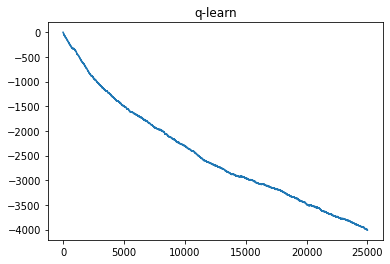

In [13]:
plt.plot(np.cumsum(learn_reward))
plt.title('q-learn')
plt.show()

Chose 0.3 as it should perform better than 0.5 if it gets good (this should be seen in the end), and at the same time it's not too low so it should explore enough.

**Question 1:**

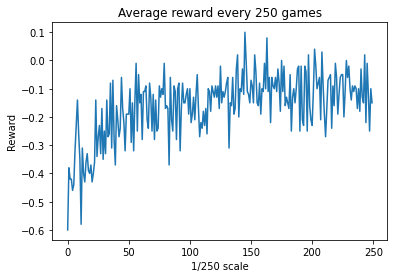

In [14]:
learn250 = np.split(np.asarray(learn_reward), 250)
averages = np.mean(learn250, axis=1)

plt.plot(averages)
plt.title('Average reward every 250 games')
plt.ylabel('Reward')
plt.xlabel('1/250 scale')
plt.show()

Yes there clearly is an upward trend. Could be reflected with stat analysis.

**Question 2 and 3:**

In [12]:
def eps(n, n_star, e_min, e_max):
    return max(e_min, e_max * (1 - (n/n_star)))

In [13]:
def M(e):
    learner_rewards = []
    for i in range(500):
        env.reset()
        grid, _, __ = env.observe()
        player_opt = OptimalPlayer(epsilon=e, player=Turns[i%2])
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                # get the q values
                q_vals = Q_actions(grid)
                # using epsilon 0
                move = epsilon_action(q_vals, 0)
                # get move in 2d format
                move = (move//3, move%3)

            grid, end, winner = env.step(move)

            if end:
                # add rewards to arrays
                learner_rewards.append(env.reward(player=Turns[(i+1)%2]))
                break
                env.reset()
    return (np.count_nonzero(np.asarray(learner_rewards) == 1) - np.count_nonzero(np.asarray(learner_rewards) == -1)) / 500

In [14]:
n_star = [*range(1, 20000, 3500)]
n_star.append(20000)
e_min = 0.1
e_max = 0.8

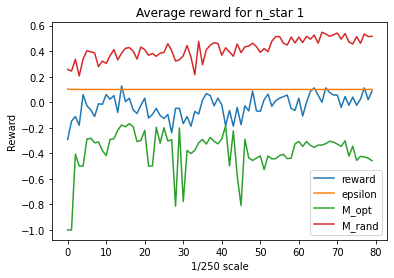

time at 0 328.13100814819336


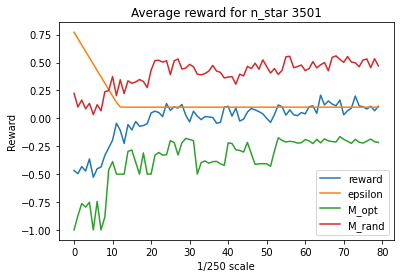

time at 1 366.9414110183716


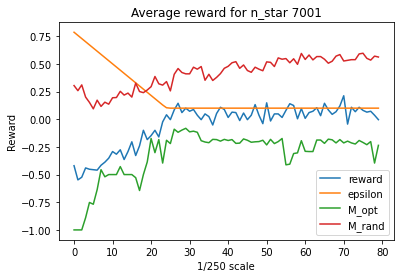

time at 2 333.0516929626465


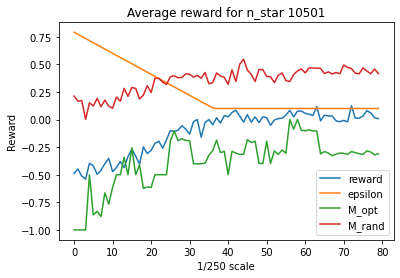

time at 3 332.84609174728394


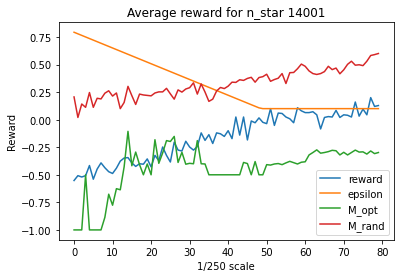

time at 4 332.4930171966553


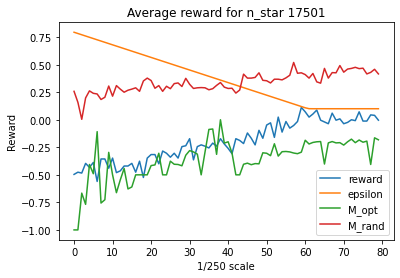

time at 5 335.7875621318817


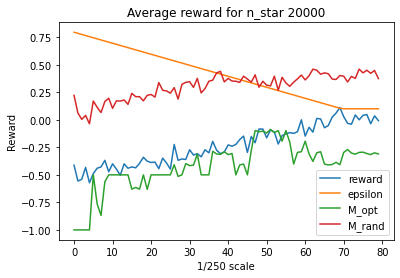

time at 6 334.120974779129


In [18]:
for y in range(len(n_star)):
    before = time.time()
    
    # reset q-values between
    Q_table = {} 
    learn_reward = []
    # array for epsilon values to plot
    eps_vals = [] 
    # arrays for M values
    M_opt = []
    M_rand = []
    for i in range(20000):
        moves = []

        env.reset()
        grid, _, __ = env.observe()
        player_opt = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                # get the q values
                q_vals = Q_actions(env.grid)
                # using new decreasing epsilon
                epsilon = eps(i, n_star[y], e_min, e_max)
                move = epsilon_action(q_vals, epsilon)
                # add position and move to array
                moves.append((np.copy(env.grid), move))
                # get move in 2d format
                move = (move//3, move%3)

            grid, end, winner = env.step(move)

            # update the Q-values, this has to be done after opt moves or when the game ends
            if (env.current_player != player_opt.player) | end:
                # get the current reward
                reward = env.reward(player=Turns[(i+1)%2])
                num_moves = len(moves)
                if num_moves >= 2:
                    position = moves[num_moves - 2][0]
                    action = moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
            if end:
                # add rewards to arrays
                learn_reward.append(env.reward(player=Turns[(i+1)%2]))
                # add to array for plotting
                eps_vals.append(epsilon) 
                env.reset()
                break
        # get the M values every 250th game
        if (i%250) == 0:
            M_opt.append(M(0))
            M_rand.append(M(1))
    # the the averages per 250 values
    learn250 = np.split(np.asarray(learn_reward), 80)
    learn_averages = np.mean(learn250, axis=1)
    eps250 = np.split(np.asarray(eps_vals), 80)
    eps_averages = np.mean(eps250, axis=1)

    title = 'Average reward for n_star ' + str(n_star[y])
    plt.plot(learn_averages, label = 'reward')
    plt.plot(eps_averages, label = 'epsilon')
    plt.plot(M_opt, label = 'M_opt')
    plt.plot(M_rand, label = 'M_rand')
    plt.title(title)
    plt.ylabel('Reward')
    plt.xlabel('1/250 scale')
    plt.legend()
    plt.show()
    
    after = time.time()
    print('time at',y,after-before)

**Q2 answer:**

We can see that it uses more time to explore before in the later stages it exploit more.

The effect of n_star seems to be that the explore phase gets extended, but it does not seem to end any higher on avg reward when it reaches 0.1 epsilon.

**Question 3:**

For the winning rate we can see that larger values seem to have more stable learning and end up higher probably as they have explored more early.

### 2.1.2
Good and bad experts

In [19]:
n_star_opt = 12000
e_min = 0.1
e_max = 0.8
e_opt = [x / 10.0 for x in range(0, 10, 2)]

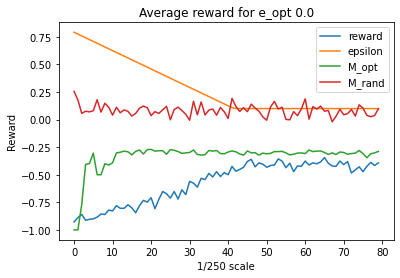

time at 0 362.74090456962585


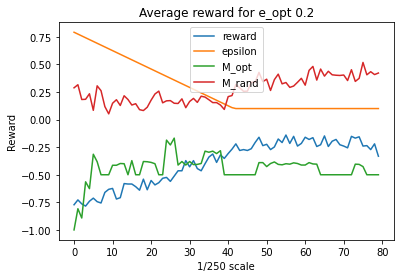

time at 1 348.47775387763977


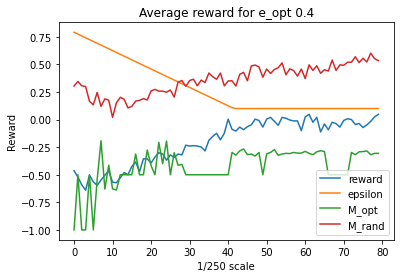

time at 2 338.63034892082214


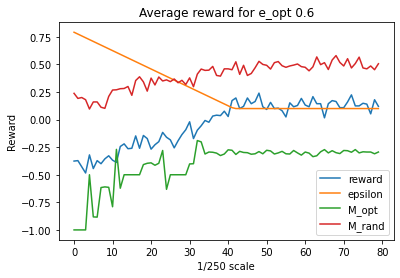

time at 3 329.9244542121887


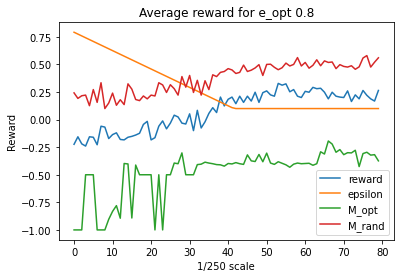

time at 4 320.1312699317932


In [20]:
for y in range(len(e_opt)):
    before = time.time()
    
    # reset q-values between
    Q_table = {} 
    learn_reward = []
    # array for epsilon values to plot
    eps_vals = [] 
    # arrays for M values
    M_opt = []
    M_rand = []
    for i in range(20000):
        moves = []

        env.reset()
        grid, _, __ = env.observe()
        player_opt = OptimalPlayer(epsilon=e_opt[y], player=Turns[i%2])
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                # get the q values
                q_vals = Q_actions(env.grid)
                # using optimal n_star decreasing epsilon
                epsilon = eps(i, n_star_opt, e_min, e_max)
                move = epsilon_action(q_vals, epsilon)
                # add position and move to array
                moves.append((np.copy(env.grid), move))
                # get move in 2d format
                move = (move//3, move%3)

            grid, end, winner = env.step(move)

            # update the Q-values, this has to be done after opt moves or when the game ends
            if (env.current_player != player_opt.player) | end:
                # get the current reward
                reward = env.reward(player=Turns[(i+1)%2])
                num_moves = len(moves)
                if num_moves >= 2:
                    position = moves[num_moves - 2][0]
                    action = moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
            if end:
                # add rewards to arrays
                learn_reward.append(env.reward(player=Turns[(i+1)%2]))
                # add to array for plotting
                eps_vals.append(epsilon) 
                env.reset()
                break
        # get the M values every 250th game
        if (i%250) == 0:
            M_opt.append(M(0))
            M_rand.append(M(1))
    # the the averages per 250 values
    learn250 = np.split(np.asarray(learn_reward), 80)
    learn_averages = np.mean(learn250, axis=1)
    eps250 = np.split(np.asarray(eps_vals), 80)
    eps_averages = np.mean(eps250, axis=1)

    title = 'Average reward for e_opt ' + str(e_opt[y])
    plt.plot(learn_averages, label = 'reward')
    plt.plot(eps_averages, label = 'epsilon')
    plt.plot(M_opt, label = 'M_opt')
    plt.plot(M_rand, label = 'M_rand')
    plt.title(title)
    plt.ylabel('Reward')
    plt.xlabel('1/250 scale')
    plt.legend()
    plt.show()
    
    after = time.time()
    print('time at',y,after-before)

There are some interesting straight lines at 0.5 for M_opt. This could be that it loses every game it does not start and draws every game it starts, or it could be due to a bug...

**Question 4:**

We observe that lower epsilon corresponds to: 
and higher epsilon corresponds to:

This can be explained by 



**Question 5:**

The highest M_opt and M_rand achieved are:

M_opt of .... for epsilon X at time :....

M_rand of .... for epsilon X at time :....

**Question 6:**

Optimal strategy against Opt(0) and optimal strategy against Opt(1) does not have to be the same..
The optimal strat described as picking middle, then corner then block etc. would good vs optimal player,

but perhaps vs random player it could be advantageous to not block win if the chance is small that it picks by random and you can win on text turn.



## 2.2

This is selfplay with fixed epsilon between 0-1.

In [21]:
e_learn = [x / 10.0 for x in range(0, 10, 2)]

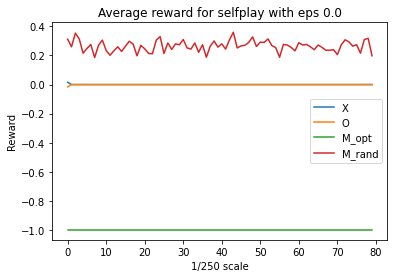

time at 0 344.8573179244995


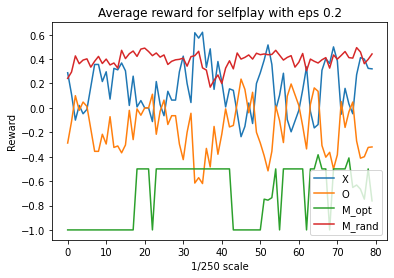

time at 1 348.3656573295593


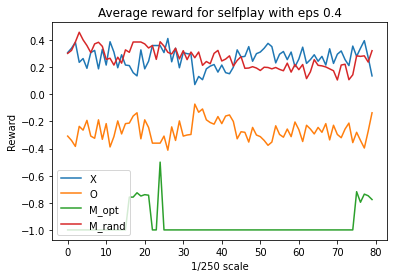

time at 2 343.84686374664307


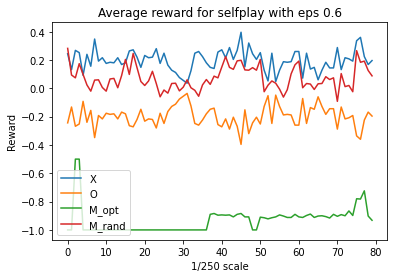

time at 3 351.1348352432251


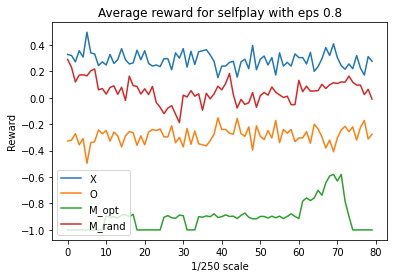

time at 4 338.9826316833496


In [22]:
for y in range(len(e_learn)):
    before = time.time()
    
    # reset q-values between
    Q_table = {} 
    a_reward = []
    b_reward = []
    # arrays for M values
    M_opt = []
    M_rand = []
    for i in range(20000):
        a_moves = []
        b_moves = []

        env.reset()
        grid, _, __ = env.observe()
        for j in range(9):
            if i%2 == 0:
                # get the q values
                q_vals = Q_actions(env.grid)
                # using epsilon from fixed values
                epsilon = e_learn[y]
                move = epsilon_action(q_vals, epsilon)
                # add position and move to array
                a_moves.append((np.copy(env.grid), move))
                # get move in 2d format
                move = (move//3, move%3)
            else:
                q_vals = Q_actions(env.grid)
                epsilon = e_learn[y]
                move = epsilon_action(q_vals, epsilon)
                # append to b_moves
                b_moves.append((np.copy(env.grid), move))
                move = (move//3, move%3)

            grid, end, winner = env.step(move)

            # update the Q-values, this has to be done after opt moves or when the game ends
            if (i%2 == 0) | end:
                # get the current reward
                reward = env.reward(player='X')
                num_moves = len(a_moves)
                if num_moves >= 2:
                    position = a_moves[num_moves - 2][0]
                    action = a_moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(a_moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
            if ((i + 1) % 2 == 0) | end:
                reward = env.reward(player='O')
                num_moves = len(b_moves)
                if num_moves >= 2:
                    position = b_moves[num_moves - 2][0]
                    action = b_moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(b_moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
                    
            if end:
                # add rewards to arrays
                a_reward.append(env.reward(player='X'))
                b_reward.append(env.reward(player='O'))
                env.reset()
                break
        # get the M values every 250th game
        if (i%250) == 0:
            M_opt.append(M(0))
            M_rand.append(M(1))
    # the the averages per 250 values
    a250 = np.split(np.asarray(a_reward), 80)
    a_averages = np.mean(a250, axis=1)
    b250 = np.split(np.asarray(b_reward), 80)
    b_averages = np.mean(b250, axis=1)
    eps250 = np.split(np.asarray(eps_vals), 80)
    eps_averages = np.mean(eps250, axis=1)

    title = 'Average reward for selfplay with eps ' + str(e_learn[y])
    plt.plot(a_averages, label = 'X')
    plt.plot(b_averages, label = 'O')
    plt.plot(M_opt, label = 'M_opt')
    plt.plot(M_rand, label = 'M_rand')
    plt.title(title)
    plt.ylabel('Reward')
    plt.xlabel('1/250 scale')
    plt.legend()
    plt.show()
    
    after = time.time()
    print('time at',y,after-before)

**Question 7:**
It seems the agent improves with selfplay tabular Q-learning, but it does not reach a high level.

The effect of epsilon seems to be:
At 0 it gets stuck and does not improve.

Above 0 it achieves some success, it seems 0.2 is the best epsilon from 0-0.4


**With varying Epsilon:** according to n_star

In [23]:
n_star = [*range(1, 20000, 3500)]
n_star.append(20000)
e_min = 0.1
e_max = 0.8

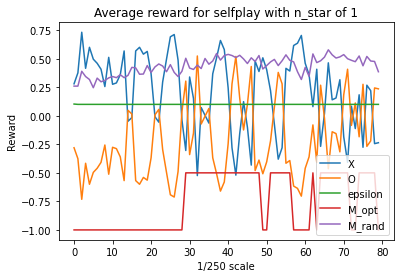

time at 0 342.06995940208435


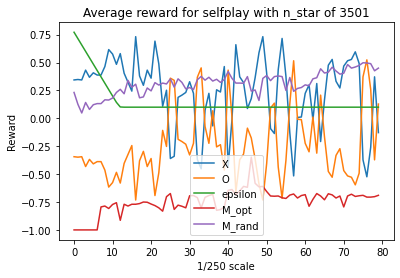

time at 1 349.9989776611328


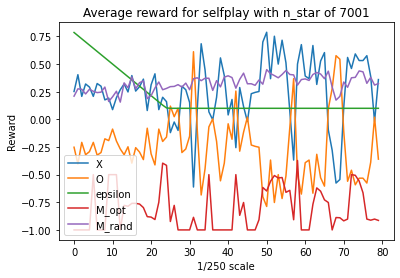

time at 2 348.3076112270355


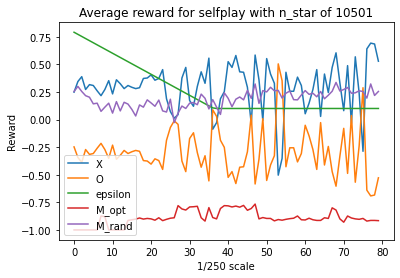

time at 3 335.5219826698303


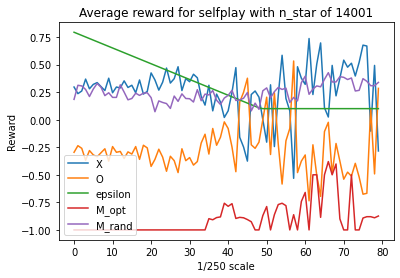

time at 4 338.86464524269104


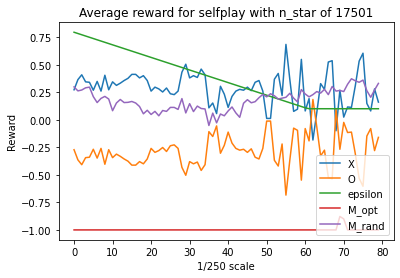

time at 5 332.84477853775024


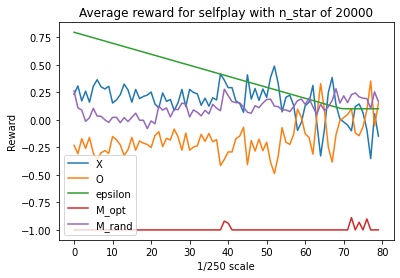

time at 6 337.0698707103729


In [24]:
for y in range(len(n_star)):
    before = time.time()
    
    # reset q-values between
    Q_table = {} 
    a_reward = []
    b_reward = []
    # array for epsilon values to plot
    eps_vals = [] 
    # arrays for M values
    M_opt = []
    M_rand = []
    for i in range(20000):
        a_moves = []
        b_moves = []

        env.reset()
        grid, _, __ = env.observe()
        for j in range(9):
            if i%2 == 0:
                # get the q values
                q_vals = Q_actions(env.grid)
                # using optimal n_star decreasing epsilon
                epsilon = eps(i, n_star[y], e_min, e_max)
                move = epsilon_action(q_vals, epsilon)
                # add position and move to array
                a_moves.append((np.copy(env.grid), move))
                # get move in 2d format
                move = (move//3, move%3)
            else:
                q_vals = Q_actions(env.grid)
                epsilon = eps(i, n_star[y], e_min, e_max)
                move = epsilon_action(q_vals, epsilon)
                # append to b_moves
                b_moves.append((np.copy(env.grid), move))
                move = (move//3, move%3)

            grid, end, winner = env.step(move)

            # update the Q-values, this has to be done after opt moves or when the game ends
            if (i%2 == 0) | end:
                # get the current reward
                reward = env.reward(player='X')
                num_moves = len(a_moves)
                if num_moves >= 2:
                    position = a_moves[num_moves - 2][0]
                    action = a_moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(a_moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
            if ((i + 1) % 2 == 0) | end:
                reward = env.reward(player='O')
                num_moves = len(b_moves)
                if num_moves >= 2:
                    position = b_moves[num_moves - 2][0]
                    action = b_moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(b_moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
                    
            if end:
                # add rewards to arrays
                a_reward.append(env.reward(player='X'))
                b_reward.append(env.reward(player='O'))
                # add to array for plotting
                eps_vals.append(epsilon) 
                env.reset()
                break
        # get the M values every 250th game
        if (i%250) == 0:
            M_opt.append(M(0))
            M_rand.append(M(1))
    # the the averages per 250 values
    a250 = np.split(np.asarray(a_reward), 80)
    a_averages = np.mean(a250, axis=1)
    b250 = np.split(np.asarray(b_reward), 80)
    b_averages = np.mean(b250, axis=1)
    eps250 = np.split(np.asarray(eps_vals), 80)
    eps_averages = np.mean(eps250, axis=1)

    title = 'Average reward for selfplay with n_star of ' + str(n_star[y])
    plt.plot(a_averages, label = 'X')
    plt.plot(b_averages, label = 'O')
    plt.plot(eps_averages, label = 'epsilon')
    plt.plot(M_opt, label = 'M_opt')
    plt.plot(M_rand, label = 'M_rand')
    plt.title(title)
    plt.ylabel('Reward')
    plt.xlabel('1/250 scale')
    plt.legend()
    plt.show()
    
    after = time.time()
    print('time at',y,after-before)

**Question 8:**
Decreasing epsilon seems to have a *** impact on learning rate.

The effect of n_star seems to be:



**Question 9:**
The highest values of M_opt and M_rand is ***


**Question 10:**
Heat map for Q-values for 3 different states S.


In [25]:
symbol_map = {'-1' : 'O', '1': 'X'}
def heatmap(pos):
    arr = Q_table[pos].reshape((3,3))
    
    fig, ax = plt.subplots()
    im = ax.imshow(arr)
    # Loop over data dimensions and create text annotations.
    for i in range(3):
        for j in range(3):
            if np.isnan(arr[i, j]):
                symbol = symbol_map[re.findall("-?\d", pos)[(3*i)+j]]
                text = ax.text(j, i, symbol,
                           ha="center", va="center")
            else:
                text = ax.text(j, i, format(arr[i, j], ".3f"),
                           ha="center", va="center")
    ax.set_title("Heatmap of Q-values")
    fig.tight_layout()
    plt.show()

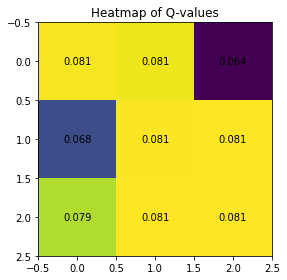

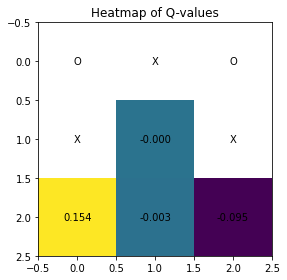

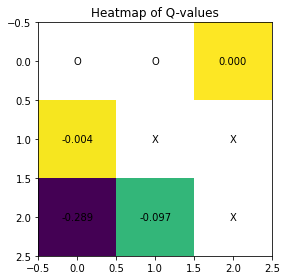

In [26]:
# 1 state for the beginning
heatmap('[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]')
# 1 state for blocking 3 in a row
heatmap('[[-1.  1. -1.]\n [ 1.  0.  1.]\n [ 0.  0.  0.]]')
# 1 state for getting 3 in a row
heatmap('[[-1. -1.  0.]\n [ 0.  1.  1.]\n [ 0.  0.  1.]]')

Makes sense?

**For 1:**
No..

**For 2:**
No, middle should be way higher value. As in next turn it will have winning move any way

**For 3:**
No... It seems to have missed the corner. Values are bad.

Did the agent learn the game well?
Not so well,

# 3 Deep Q-Learning

Implement it like in [https://keras.io/examples/rl/deep_q_network_breakout/]

In [14]:
example_grid = np.array([[1,-1,0],[0,1,-1],[-1,1,0]])
example_grid

array([[ 1, -1,  0],
       [ 0,  1, -1],
       [-1,  1,  0]])

In [15]:
def grid_to_tensor(grid):
    x = (grid == 1).astype(int)
    o = (grid == -1).astype(int)
    return np.dstack([x,o])

In [16]:
# demonstrate that it transforms to tensor the right way
print(grid_to_tensor(example_grid))
print(grid_to_tensor(example_grid).shape)

[[[1 0]
  [0 1]
  [0 0]]

 [[0 0]
  [1 0]
  [0 1]]

 [[0 1]
  [1 0]
  [0 0]]]
(3, 3, 2)


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 0.2 # the fixed epsilon parameter for question 11
batch_size = 64  # Size of batch taken from replay buffer
update_step = 500 #update at every 500 step
buffer_size = 10000

num_actions = 9

max_memory_length = 10000

rng = np.random.default_rng(499)

In [21]:
def create_q_model():
    inputs = layers.Input(shape=(3, 3, 2))
    layer1 = layers.Dense(128, activation="relu")(inputs)
    layer2 = layers.Dense(128, activation="relu")(layer1)
    layer3 = layers.Flatten()(layer2)
    action = layers.Dense(9, activation="linear")(layer3)

    return keras.Model(inputs=inputs, outputs=action)

#using adam optimizer with learning rate 5e-4
optimizer = keras.optimizers.Adam(learning_rate=5e-4)

# Using huber loss for stability
loss_function = keras.losses.Huber()

model = create_q_model()
model_target = create_q_model()

for layer in create_q_model().layers:
    print(layer.input_shape)

[(None, 3, 3, 2)]
(None, 3, 3, 2)
(None, 3, 3, 128)
(None, 3, 3, 128)
(None, 1152)


In [43]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
losses = []
running_reward = 0
episode_count = 0

for i in range(20000):  # run 20000 times
    before = time.time()
    env.reset()
    episode_reward = 0

    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
    for j in range(9):
        state = np.copy(env.grid)
        done = False
        reward = 0
        illegal = False
        
        if env.current_player == player_opt.player:
            action_2d = player_opt.act(grid)
        else:
            # Use epsilon-greedy for exploration
            if epsilon > rng.random():
                # Take random action
                action = rng.choice(num_actions)
                action_2d = (action//3, action%3)
            else:
                # Predict action Q-values
                # From environment state
                state_tensor = grid_to_tensor(env.grid)
                state_tensor = tf.expand_dims(state_tensor, 0)
                action_probs = model(state_tensor, training=False)
                # Take best action
                action = tf.argmax(action_probs[0]).numpy()
                action_2d = (action//3, action%3)
        
        # if taking illegal move
        if state[action_2d[0]][action_2d[1]] != 0:
            reward = -1
            done = True #finish game
            episode_reward += reward
            # Save actions and states in replay buffer
            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            #set illegal true to not push values twice
            illegal = True
            
        if not done:
            state_next, end, winner = env.step(action_2d)
        
        if (env.current_player == player_opt.player) & (not illegal):
            episode_reward += reward
            # Save actions and states in replay buffer
            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            state = state_next

        # Update after every game
        if done:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            # reshape to 64, 3, 3, 2
            future_rewards = model_target.predict(np.array([grid_to_tensor(x) for x in state_next_sample]))
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                # reshape to 64, 3, 3, 2
                q_values = model(np.array([grid_to_tensor(x) for x in state_sample]))

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)
                losses.append(loss)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "reward: {:.2f} at episode {}"
            print(template.format(reward, episode_count), 'time used:', time.time() - before)

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

reward: -1.00 at episode 0 time used: 0.12357854843139648
reward: -1.00 at episode 1 time used: 0.12243390083312988
reward: -1.00 at episode 2 time used: 0.09959578514099121
reward: -1.00 at episode 3 time used: 0.08986496925354004
reward: -1.00 at episode 4 time used: 0.09663748741149902
reward: -1.00 at episode 5 time used: 0.09559392929077148
reward: -1.00 at episode 6 time used: 0.12063908576965332
reward: -1.00 at episode 7 time used: 0.14047026634216309
reward: -1.00 at episode 8 time used: 0.10933494567871094
reward: -1.00 at episode 9 time used: 0.12902140617370605
reward: -1.00 at episode 10 time used: 0.13384032249450684
reward: -1.00 at episode 11 time used: 0.09971237182617188
reward: -1.00 at episode 12 time used: 0.12172460556030273
reward: -1.00 at episode 13 time used: 0.10553455352783203
reward: -1.00 at episode 14 time used: 0.09896087646484375
reward: -1.00 at episode 15 time used: 0.11838769912719727
reward: -1.00 at episode 16 time used: 0.11572718620300293
reward:

reward: -1.00 at episode 139 time used: 0.14105629920959473
reward: -1.00 at episode 140 time used: 0.12150692939758301
reward: -1.00 at episode 141 time used: 0.09580731391906738
reward: -1.00 at episode 142 time used: 0.0951378345489502
reward: -1.00 at episode 143 time used: 0.10057830810546875
reward: -1.00 at episode 144 time used: 0.11174821853637695
reward: -1.00 at episode 145 time used: 0.12130284309387207
reward: -1.00 at episode 146 time used: 0.1276712417602539
reward: -1.00 at episode 147 time used: 0.13141775131225586
reward: -1.00 at episode 148 time used: 0.10304045677185059
reward: -1.00 at episode 149 time used: 0.1026601791381836
reward: -1.00 at episode 150 time used: 0.1253526210784912
reward: -1.00 at episode 151 time used: 0.11137557029724121
reward: -1.00 at episode 152 time used: 0.09087920188903809
reward: -1.00 at episode 153 time used: 0.11330842971801758
reward: -1.00 at episode 154 time used: 0.10463356971740723
reward: -1.00 at episode 155 time used: 0.11

reward: -1.00 at episode 278 time used: 0.09940266609191895
reward: -1.00 at episode 279 time used: 0.11699604988098145
reward: -1.00 at episode 280 time used: 0.11959123611450195
reward: -1.00 at episode 281 time used: 0.10450315475463867
reward: -1.00 at episode 282 time used: 0.09632396697998047
reward: -1.00 at episode 283 time used: 0.10615420341491699
reward: -1.00 at episode 284 time used: 0.09103918075561523
reward: -1.00 at episode 285 time used: 0.09351754188537598
reward: -1.00 at episode 286 time used: 0.11752986907958984
reward: -1.00 at episode 287 time used: 0.11873030662536621
reward: -1.00 at episode 288 time used: 0.09952497482299805
reward: -1.00 at episode 289 time used: 0.09682345390319824
reward: -1.00 at episode 290 time used: 0.09797477722167969
reward: -1.00 at episode 291 time used: 0.06454920768737793
reward: -1.00 at episode 292 time used: 0.10039663314819336
reward: -1.00 at episode 293 time used: 0.09746003150939941
reward: -1.00 at episode 294 time used: 

reward: -1.00 at episode 415 time used: 0.10177421569824219
reward: -1.00 at episode 416 time used: 0.06760096549987793
reward: -1.00 at episode 417 time used: 0.10957050323486328
reward: -1.00 at episode 418 time used: 0.09073209762573242
reward: -1.00 at episode 419 time used: 0.09838724136352539
reward: -1.00 at episode 420 time used: 0.11412191390991211
reward: -1.00 at episode 421 time used: 0.09858965873718262
reward: -1.00 at episode 422 time used: 0.10272526741027832
reward: -1.00 at episode 423 time used: 0.1090543270111084
reward: -1.00 at episode 424 time used: 0.1104738712310791
reward: -1.00 at episode 425 time used: 0.1057729721069336
reward: -1.00 at episode 426 time used: 0.10512781143188477
reward: -1.00 at episode 427 time used: 0.12273168563842773
reward: -1.00 at episode 428 time used: 0.09658479690551758
reward: -1.00 at episode 429 time used: 0.0989987850189209
reward: -1.00 at episode 430 time used: 0.1091160774230957
reward: -1.00 at episode 431 time used: 0.083

reward: -1.00 at episode 553 time used: 0.10797357559204102
reward: -1.00 at episode 554 time used: 0.09303569793701172
reward: -1.00 at episode 555 time used: 0.12743234634399414
reward: -1.00 at episode 556 time used: 0.09901046752929688
reward: -1.00 at episode 557 time used: 0.13674449920654297
reward: -1.00 at episode 558 time used: 0.1086726188659668
reward: -1.00 at episode 559 time used: 0.11186337471008301
reward: -1.00 at episode 560 time used: 0.09418058395385742
reward: -1.00 at episode 561 time used: 0.10454940795898438
reward: -1.00 at episode 562 time used: 0.09694170951843262
reward: -1.00 at episode 563 time used: 0.09414005279541016
reward: -1.00 at episode 564 time used: 0.08661437034606934
reward: -1.00 at episode 565 time used: 0.10480427742004395
reward: -1.00 at episode 566 time used: 0.11206912994384766
reward: -1.00 at episode 567 time used: 0.10828924179077148
reward: -1.00 at episode 568 time used: 0.10825634002685547
reward: -1.00 at episode 569 time used: 0

reward: -1.00 at episode 693 time used: 0.1060640811920166
reward: -1.00 at episode 694 time used: 0.0990290641784668
reward: -1.00 at episode 695 time used: 0.09647059440612793
reward: -1.00 at episode 696 time used: 0.09374618530273438
reward: -1.00 at episode 697 time used: 0.09705758094787598
reward: -1.00 at episode 698 time used: 0.12390971183776855
reward: -1.00 at episode 699 time used: 0.08509349822998047
reward: -1.00 at episode 700 time used: 0.08950948715209961
reward: -1.00 at episode 701 time used: 0.0834197998046875
reward: -1.00 at episode 702 time used: 0.09396100044250488
reward: -1.00 at episode 703 time used: 0.09751415252685547
reward: -1.00 at episode 704 time used: 0.09274935722351074
reward: -1.00 at episode 705 time used: 0.09920835494995117
reward: -1.00 at episode 706 time used: 0.09486985206604004
reward: -1.00 at episode 707 time used: 0.10595178604125977
reward: -1.00 at episode 708 time used: 0.08544135093688965
reward: -1.00 at episode 709 time used: 0.0

reward: -1.00 at episode 831 time used: 0.11344504356384277
reward: -1.00 at episode 832 time used: 0.09127068519592285
reward: -1.00 at episode 833 time used: 0.11882233619689941
reward: -1.00 at episode 834 time used: 0.08915829658508301
reward: -1.00 at episode 835 time used: 0.09938549995422363
reward: -1.00 at episode 836 time used: 0.08858299255371094
reward: -1.00 at episode 837 time used: 0.08169126510620117
reward: -1.00 at episode 838 time used: 0.08403921127319336
reward: -1.00 at episode 839 time used: 0.08051180839538574
reward: -1.00 at episode 840 time used: 0.10404753684997559
reward: -1.00 at episode 841 time used: 0.09913015365600586
reward: -1.00 at episode 842 time used: 0.12157440185546875
reward: -1.00 at episode 843 time used: 0.09924602508544922
reward: -1.00 at episode 844 time used: 0.0982046127319336
reward: -1.00 at episode 845 time used: 0.06800007820129395
reward: -1.00 at episode 846 time used: 0.10431766510009766
reward: -1.00 at episode 847 time used: 0

reward: -1.00 at episode 968 time used: 0.09439444541931152
reward: -1.00 at episode 969 time used: 0.08512043952941895
reward: -1.00 at episode 970 time used: 0.12559771537780762
reward: -1.00 at episode 971 time used: 0.07926726341247559
reward: -1.00 at episode 972 time used: 0.10207605361938477
reward: -1.00 at episode 973 time used: 0.13138508796691895
reward: -1.00 at episode 974 time used: 0.10520076751708984
reward: -1.00 at episode 975 time used: 0.10553956031799316
reward: -1.00 at episode 976 time used: 0.10442972183227539
reward: -1.00 at episode 977 time used: 0.11285805702209473
reward: -1.00 at episode 978 time used: 0.10872817039489746
reward: -1.00 at episode 979 time used: 0.09660983085632324
reward: -1.00 at episode 980 time used: 0.08332610130310059
reward: -1.00 at episode 981 time used: 0.11230874061584473
reward: -1.00 at episode 982 time used: 0.09175705909729004
reward: -1.00 at episode 983 time used: 0.0926365852355957
reward: -1.00 at episode 984 time used: 0

reward: -1.00 at episode 1105 time used: 0.11088776588439941
reward: -1.00 at episode 1106 time used: 0.07553529739379883
reward: -1.00 at episode 1107 time used: 0.09368610382080078
reward: -1.00 at episode 1108 time used: 0.12119388580322266
reward: -1.00 at episode 1109 time used: 0.10277915000915527
reward: -1.00 at episode 1110 time used: 0.07973551750183105
reward: -1.00 at episode 1111 time used: 0.09895825386047363
reward: -1.00 at episode 1112 time used: 0.09245514869689941
reward: -1.00 at episode 1113 time used: 0.06794023513793945
reward: -1.00 at episode 1114 time used: 0.08296346664428711
reward: -1.00 at episode 1115 time used: 0.09802007675170898
reward: -1.00 at episode 1116 time used: 0.09840822219848633
reward: -1.00 at episode 1117 time used: 0.09783601760864258
reward: -1.00 at episode 1118 time used: 0.08552408218383789
reward: -1.00 at episode 1119 time used: 0.07617902755737305
reward: -1.00 at episode 1120 time used: 0.07690787315368652
reward: -1.00 at episode

reward: -1.00 at episode 1240 time used: 0.12433838844299316
reward: -1.00 at episode 1241 time used: 0.09801530838012695
reward: -1.00 at episode 1242 time used: 0.10274600982666016
reward: -1.00 at episode 1243 time used: 0.10353302955627441
reward: -1.00 at episode 1244 time used: 0.08934807777404785
reward: -1.00 at episode 1245 time used: 0.10483670234680176
reward: -1.00 at episode 1246 time used: 0.09460282325744629
reward: -1.00 at episode 1247 time used: 0.06783533096313477
reward: -1.00 at episode 1248 time used: 0.09027361869812012
reward: -1.00 at episode 1249 time used: 0.10447835922241211
reward: -1.00 at episode 1250 time used: 0.09710001945495605
reward: -1.00 at episode 1251 time used: 0.12798142433166504
reward: -1.00 at episode 1252 time used: 0.08999967575073242
reward: -1.00 at episode 1253 time used: 0.07732081413269043
reward: -1.00 at episode 1254 time used: 0.09227347373962402
reward: -1.00 at episode 1255 time used: 0.1254746913909912
reward: -1.00 at episode 

reward: -1.00 at episode 1377 time used: 0.1061253547668457
reward: -1.00 at episode 1378 time used: 0.09004807472229004
reward: -1.00 at episode 1379 time used: 0.07466268539428711
reward: -1.00 at episode 1380 time used: 0.08864092826843262
reward: -1.00 at episode 1381 time used: 0.10551118850708008
reward: -1.00 at episode 1382 time used: 0.09839344024658203
reward: -1.00 at episode 1383 time used: 0.08999991416931152
reward: -1.00 at episode 1384 time used: 0.09716105461120605
reward: -1.00 at episode 1385 time used: 0.11322999000549316
reward: -1.00 at episode 1386 time used: 0.08647632598876953
reward: -1.00 at episode 1387 time used: 0.10364246368408203
reward: -1.00 at episode 1388 time used: 0.0913541316986084
reward: -1.00 at episode 1389 time used: 0.08214402198791504
reward: -1.00 at episode 1390 time used: 0.09283304214477539
reward: -1.00 at episode 1391 time used: 0.1121666431427002
reward: -1.00 at episode 1392 time used: 0.09275603294372559
reward: -1.00 at episode 13

reward: -1.00 at episode 1512 time used: 0.09737658500671387
reward: -1.00 at episode 1513 time used: 0.10922527313232422
reward: -1.00 at episode 1514 time used: 0.09485983848571777
reward: -1.00 at episode 1515 time used: 0.08104634284973145
reward: -1.00 at episode 1516 time used: 0.1004631519317627
reward: -1.00 at episode 1517 time used: 0.09081125259399414
reward: -1.00 at episode 1518 time used: 0.10992789268493652
reward: -1.00 at episode 1519 time used: 0.0943596363067627
reward: -1.00 at episode 1520 time used: 0.08906888961791992
reward: -1.00 at episode 1521 time used: 0.1372535228729248
reward: -1.00 at episode 1522 time used: 0.1077115535736084
reward: -1.00 at episode 1523 time used: 0.10356664657592773
reward: -1.00 at episode 1524 time used: 0.10305213928222656
reward: -1.00 at episode 1525 time used: 0.07581949234008789
reward: -1.00 at episode 1526 time used: 0.09446334838867188
reward: -1.00 at episode 1527 time used: 0.11319947242736816
reward: -1.00 at episode 152

reward: -1.00 at episode 1649 time used: 0.11324381828308105
reward: -1.00 at episode 1650 time used: 0.08463025093078613
reward: -1.00 at episode 1651 time used: 0.0910799503326416
reward: -1.00 at episode 1652 time used: 0.07310247421264648
reward: -1.00 at episode 1653 time used: 0.0705118179321289
reward: -1.00 at episode 1654 time used: 0.10266947746276855
reward: -1.00 at episode 1655 time used: 0.09298992156982422
reward: -1.00 at episode 1656 time used: 0.10651993751525879
reward: -1.00 at episode 1657 time used: 0.1006782054901123
reward: -1.00 at episode 1658 time used: 0.09256505966186523
reward: -1.00 at episode 1659 time used: 0.10295605659484863
reward: -1.00 at episode 1660 time used: 0.07302451133728027
reward: -1.00 at episode 1661 time used: 0.11047697067260742
reward: -1.00 at episode 1662 time used: 0.10893917083740234
reward: -1.00 at episode 1663 time used: 0.0706784725189209
reward: -1.00 at episode 1664 time used: 0.10238194465637207
reward: -1.00 at episode 166

reward: -1.00 at episode 1786 time used: 0.10308599472045898
reward: -1.00 at episode 1787 time used: 0.10651588439941406
reward: -1.00 at episode 1788 time used: 0.08694767951965332
reward: -1.00 at episode 1789 time used: 0.11066460609436035
reward: -1.00 at episode 1790 time used: 0.10176682472229004
reward: -1.00 at episode 1791 time used: 0.10846304893493652
reward: -1.00 at episode 1792 time used: 0.1040952205657959
reward: -1.00 at episode 1793 time used: 0.07674717903137207
reward: -1.00 at episode 1794 time used: 0.08223342895507812
reward: -1.00 at episode 1795 time used: 0.09087944030761719
reward: -1.00 at episode 1796 time used: 0.09195661544799805
reward: -1.00 at episode 1797 time used: 0.10305976867675781
reward: -1.00 at episode 1798 time used: 0.09343099594116211
reward: -1.00 at episode 1799 time used: 0.0983421802520752
reward: -1.00 at episode 1800 time used: 0.12060785293579102
reward: -1.00 at episode 1801 time used: 0.09380054473876953
reward: -1.00 at episode 1

reward: -1.00 at episode 1922 time used: 0.11433076858520508
reward: -1.00 at episode 1923 time used: 0.13277697563171387
reward: -1.00 at episode 1924 time used: 0.10299968719482422
reward: -1.00 at episode 1925 time used: 0.09597253799438477
reward: -1.00 at episode 1926 time used: 0.09126019477844238
reward: -1.00 at episode 1927 time used: 0.09535408020019531
reward: -1.00 at episode 1928 time used: 0.0721590518951416
reward: -1.00 at episode 1929 time used: 0.07678508758544922
reward: -1.00 at episode 1930 time used: 0.09545397758483887
reward: -1.00 at episode 1931 time used: 0.09100770950317383
reward: -1.00 at episode 1932 time used: 0.09601688385009766
reward: -1.00 at episode 1933 time used: 0.08209443092346191
reward: -1.00 at episode 1934 time used: 0.0895845890045166
reward: -1.00 at episode 1935 time used: 0.09061574935913086
reward: -1.00 at episode 1936 time used: 0.10045981407165527
reward: -1.00 at episode 1937 time used: 0.08720803260803223
reward: -1.00 at episode 1

reward: -1.00 at episode 2057 time used: 0.08881330490112305
reward: -1.00 at episode 2058 time used: 0.10577750205993652
reward: -1.00 at episode 2059 time used: 0.11724090576171875
reward: -1.00 at episode 2060 time used: 0.09215307235717773
reward: -1.00 at episode 2061 time used: 0.10900044441223145
reward: -1.00 at episode 2062 time used: 0.09000396728515625
reward: -1.00 at episode 2063 time used: 0.09180784225463867
reward: -1.00 at episode 2064 time used: 0.0914914608001709
reward: -1.00 at episode 2065 time used: 0.08615541458129883
reward: -1.00 at episode 2066 time used: 0.09395170211791992
reward: -1.00 at episode 2067 time used: 0.09125113487243652
reward: -1.00 at episode 2068 time used: 0.09435009956359863
reward: -1.00 at episode 2069 time used: 0.1073751449584961
reward: -1.00 at episode 2070 time used: 0.08375024795532227
reward: -1.00 at episode 2071 time used: 0.10001111030578613
reward: -1.00 at episode 2072 time used: 0.09299683570861816
reward: -1.00 at episode 2

reward: -1.00 at episode 2194 time used: 0.0890202522277832
reward: -1.00 at episode 2195 time used: 0.09844470024108887
reward: -1.00 at episode 2196 time used: 0.09452581405639648
reward: -1.00 at episode 2197 time used: 0.09457063674926758
reward: -1.00 at episode 2198 time used: 0.1021265983581543
reward: -1.00 at episode 2199 time used: 0.10400724411010742
reward: -1.00 at episode 2200 time used: 0.09059858322143555
reward: -1.00 at episode 2201 time used: 0.08800458908081055
reward: -1.00 at episode 2202 time used: 0.10586929321289062
reward: -1.00 at episode 2203 time used: 0.11580181121826172
reward: -1.00 at episode 2204 time used: 0.10899972915649414
reward: -1.00 at episode 2205 time used: 0.14121508598327637
reward: -1.00 at episode 2206 time used: 0.09422111511230469
reward: -1.00 at episode 2207 time used: 0.09599804878234863
reward: -1.00 at episode 2208 time used: 0.10138058662414551
reward: -1.00 at episode 2209 time used: 0.08754301071166992
reward: -1.00 at episode 2

reward: -1.00 at episode 2331 time used: 0.0985107421875
reward: -1.00 at episode 2332 time used: 0.10504412651062012
reward: -1.00 at episode 2333 time used: 0.09905099868774414
reward: -1.00 at episode 2334 time used: 0.09268426895141602
reward: -1.00 at episode 2335 time used: 0.09769725799560547
reward: -1.00 at episode 2336 time used: 0.0929257869720459
reward: -1.00 at episode 2337 time used: 0.09308052062988281
reward: -1.00 at episode 2338 time used: 0.0992422103881836
reward: -1.00 at episode 2339 time used: 0.06475043296813965
reward: -1.00 at episode 2340 time used: 0.08016252517700195
reward: -1.00 at episode 2341 time used: 0.12781476974487305
reward: -1.00 at episode 2342 time used: 0.11578559875488281
reward: -1.00 at episode 2343 time used: 0.09999394416809082
reward: -1.00 at episode 2344 time used: 0.0820000171661377
reward: -1.00 at episode 2345 time used: 0.09685635566711426
reward: -1.00 at episode 2346 time used: 0.0996098518371582
reward: -1.00 at episode 2347 ti

reward: -1.00 at episode 2467 time used: 0.12102627754211426
reward: -1.00 at episode 2468 time used: 0.10292840003967285
reward: -1.00 at episode 2469 time used: 0.08191752433776855
reward: -1.00 at episode 2470 time used: 0.0971832275390625
reward: -1.00 at episode 2471 time used: 0.09499859809875488
reward: -1.00 at episode 2472 time used: 0.09801530838012695
reward: -1.00 at episode 2473 time used: 0.09175491333007812
reward: -1.00 at episode 2474 time used: 0.09288716316223145
reward: -1.00 at episode 2475 time used: 0.08764100074768066
reward: -1.00 at episode 2476 time used: 0.08281803131103516
reward: -1.00 at episode 2477 time used: 0.06313467025756836
reward: -1.00 at episode 2478 time used: 0.08132386207580566
reward: -1.00 at episode 2479 time used: 0.09409475326538086
reward: -1.00 at episode 2480 time used: 0.10242962837219238
reward: -1.00 at episode 2481 time used: 0.10381674766540527
reward: -1.00 at episode 2482 time used: 0.0967104434967041
reward: -1.00 at episode 2

reward: -1.00 at episode 2603 time used: 0.10016965866088867
reward: -1.00 at episode 2604 time used: 0.09447002410888672
reward: -1.00 at episode 2605 time used: 0.10294461250305176
reward: -1.00 at episode 2606 time used: 0.06839966773986816
reward: -1.00 at episode 2607 time used: 0.09778976440429688
reward: -1.00 at episode 2608 time used: 0.07353758811950684
reward: -1.00 at episode 2609 time used: 0.09114813804626465
reward: -1.00 at episode 2610 time used: 0.0867612361907959
reward: -1.00 at episode 2611 time used: 0.07581710815429688
reward: -1.00 at episode 2612 time used: 0.10366511344909668
reward: -1.00 at episode 2613 time used: 0.10961675643920898
reward: -1.00 at episode 2614 time used: 0.09829020500183105
reward: -1.00 at episode 2615 time used: 0.07786059379577637
reward: -1.00 at episode 2616 time used: 0.0900275707244873
reward: -1.00 at episode 2617 time used: 0.10459256172180176
reward: -1.00 at episode 2618 time used: 0.1158297061920166
reward: -1.00 at episode 26

reward: -1.00 at episode 2739 time used: 0.11678290367126465
reward: -1.00 at episode 2740 time used: 0.09600186347961426
reward: -1.00 at episode 2741 time used: 0.10511469841003418
reward: -1.00 at episode 2742 time used: 0.09742355346679688
reward: -1.00 at episode 2743 time used: 0.0702672004699707
reward: -1.00 at episode 2744 time used: 0.0916445255279541
reward: -1.00 at episode 2745 time used: 0.09143757820129395
reward: -1.00 at episode 2746 time used: 0.08715367317199707
reward: -1.00 at episode 2747 time used: 0.09953951835632324
reward: -1.00 at episode 2748 time used: 0.09800386428833008
reward: -1.00 at episode 2749 time used: 0.10599541664123535
reward: -1.00 at episode 2750 time used: 0.11362791061401367
reward: -1.00 at episode 2751 time used: 0.09600305557250977
reward: -1.00 at episode 2752 time used: 0.0805501937866211
reward: -1.00 at episode 2753 time used: 0.08177065849304199
reward: -1.00 at episode 2754 time used: 0.08504462242126465
reward: -1.00 at episode 27

reward: -1.00 at episode 2874 time used: 0.08234095573425293
reward: -1.00 at episode 2875 time used: 0.09196615219116211
reward: -1.00 at episode 2876 time used: 0.1019742488861084
reward: -1.00 at episode 2877 time used: 0.11317110061645508
reward: -1.00 at episode 2878 time used: 0.11251688003540039
reward: -1.00 at episode 2879 time used: 0.10823655128479004
reward: -1.00 at episode 2880 time used: 0.09162402153015137
reward: -1.00 at episode 2881 time used: 0.09401369094848633
reward: -1.00 at episode 2882 time used: 0.07750463485717773
reward: -1.00 at episode 2883 time used: 0.1099240779876709
reward: -1.00 at episode 2884 time used: 0.10763239860534668
reward: -1.00 at episode 2885 time used: 0.10110330581665039
reward: -1.00 at episode 2886 time used: 0.11591029167175293
reward: -1.00 at episode 2887 time used: 0.08998942375183105
reward: -1.00 at episode 2888 time used: 0.09343552589416504
reward: -1.00 at episode 2889 time used: 0.10183310508728027
reward: -1.00 at episode 2

reward: -1.00 at episode 3009 time used: 0.07500481605529785
reward: -1.00 at episode 3010 time used: 0.1106722354888916
reward: -1.00 at episode 3011 time used: 0.10971522331237793
reward: -1.00 at episode 3012 time used: 0.11384105682373047
reward: -1.00 at episode 3013 time used: 0.13163423538208008
reward: -1.00 at episode 3014 time used: 0.0937657356262207
reward: -1.00 at episode 3015 time used: 0.08876299858093262
reward: -1.00 at episode 3016 time used: 0.07661724090576172
reward: -1.00 at episode 3017 time used: 0.09139084815979004
reward: -1.00 at episode 3018 time used: 0.11094808578491211
reward: -1.00 at episode 3019 time used: 0.10167217254638672
reward: -1.00 at episode 3020 time used: 0.10200142860412598
reward: -1.00 at episode 3021 time used: 0.10277938842773438
reward: -1.00 at episode 3022 time used: 0.10050296783447266
reward: -1.00 at episode 3023 time used: 0.11378240585327148
reward: -1.00 at episode 3024 time used: 0.09913873672485352
reward: -1.00 at episode 3

reward: -1.00 at episode 3145 time used: 0.09783554077148438
reward: -1.00 at episode 3146 time used: 0.12658286094665527
reward: -1.00 at episode 3147 time used: 0.1433565616607666
reward: -1.00 at episode 3148 time used: 0.1036226749420166
reward: -1.00 at episode 3149 time used: 0.13504481315612793
reward: -1.00 at episode 3150 time used: 0.10854983329772949
reward: -1.00 at episode 3151 time used: 0.13558435440063477
reward: -1.00 at episode 3152 time used: 0.13610219955444336
reward: -1.00 at episode 3153 time used: 0.14199233055114746
reward: -1.00 at episode 3154 time used: 0.12268376350402832
reward: -1.00 at episode 3155 time used: 0.14299535751342773
reward: -1.00 at episode 3156 time used: 0.1437544822692871
reward: -1.00 at episode 3157 time used: 0.12018537521362305
reward: -1.00 at episode 3158 time used: 0.15242433547973633
reward: -1.00 at episode 3159 time used: 0.11303138732910156
reward: -1.00 at episode 3160 time used: 0.12028241157531738
reward: -1.00 at episode 31

reward: -1.00 at episode 3281 time used: 0.0969548225402832
reward: -1.00 at episode 3282 time used: 0.10701966285705566
reward: -1.00 at episode 3283 time used: 0.07994318008422852
reward: -1.00 at episode 3284 time used: 0.10514545440673828
reward: -1.00 at episode 3285 time used: 0.08353710174560547
reward: -1.00 at episode 3286 time used: 0.09802389144897461
reward: -1.00 at episode 3287 time used: 0.10300898551940918
reward: -1.00 at episode 3288 time used: 0.10131072998046875
reward: -1.00 at episode 3289 time used: 0.07978391647338867
reward: -1.00 at episode 3290 time used: 0.09837460517883301
reward: -1.00 at episode 3291 time used: 0.09096598625183105
reward: -1.00 at episode 3292 time used: 0.08622407913208008
reward: -1.00 at episode 3293 time used: 0.09291958808898926
reward: -1.00 at episode 3294 time used: 0.09090042114257812
reward: -1.00 at episode 3295 time used: 0.09899353981018066
reward: -1.00 at episode 3296 time used: 0.10422635078430176
reward: -1.00 at episode 

reward: -1.00 at episode 3416 time used: 0.09197592735290527
reward: -1.00 at episode 3417 time used: 0.10347604751586914
reward: -1.00 at episode 3418 time used: 0.09941339492797852
reward: -1.00 at episode 3419 time used: 0.10169124603271484
reward: -1.00 at episode 3420 time used: 0.09018874168395996
reward: -1.00 at episode 3421 time used: 0.11934995651245117
reward: -1.00 at episode 3422 time used: 0.09464120864868164
reward: -1.00 at episode 3423 time used: 0.10041141510009766
reward: -1.00 at episode 3424 time used: 0.09598445892333984
reward: -1.00 at episode 3425 time used: 0.08593392372131348
reward: -1.00 at episode 3426 time used: 0.08488655090332031
reward: -1.00 at episode 3427 time used: 0.08606314659118652
reward: -1.00 at episode 3428 time used: 0.10772228240966797
reward: -1.00 at episode 3429 time used: 0.09545111656188965
reward: -1.00 at episode 3430 time used: 0.10186266899108887
reward: -1.00 at episode 3431 time used: 0.10812902450561523
reward: -1.00 at episode

reward: -1.00 at episode 3552 time used: 0.10589814186096191
reward: -1.00 at episode 3553 time used: 0.11182355880737305
reward: -1.00 at episode 3554 time used: 0.06922030448913574
reward: -1.00 at episode 3555 time used: 0.11505436897277832
reward: -1.00 at episode 3556 time used: 0.10499835014343262
reward: -1.00 at episode 3557 time used: 0.10204267501831055
reward: -1.00 at episode 3558 time used: 0.05800676345825195
reward: -1.00 at episode 3559 time used: 0.10697364807128906
reward: -1.00 at episode 3560 time used: 0.08815789222717285
reward: -1.00 at episode 3561 time used: 0.09700250625610352
reward: -1.00 at episode 3562 time used: 0.09802961349487305
reward: -1.00 at episode 3563 time used: 0.12662959098815918
reward: -1.00 at episode 3564 time used: 0.08232474327087402
reward: -1.00 at episode 3565 time used: 0.09868955612182617
reward: -1.00 at episode 3566 time used: 0.10484552383422852
reward: -1.00 at episode 3567 time used: 0.10901165008544922
reward: -1.00 at episode

reward: -1.00 at episode 3687 time used: 0.10661840438842773
reward: -1.00 at episode 3688 time used: 0.09291338920593262
reward: -1.00 at episode 3689 time used: 0.09861350059509277
reward: -1.00 at episode 3690 time used: 0.07330322265625
reward: -1.00 at episode 3691 time used: 0.09926342964172363
reward: -1.00 at episode 3692 time used: 0.10394668579101562
reward: -1.00 at episode 3693 time used: 0.12999701499938965
reward: -1.00 at episode 3694 time used: 0.10899782180786133
reward: -1.00 at episode 3695 time used: 0.11230230331420898
reward: -1.00 at episode 3696 time used: 0.1184377670288086
reward: -1.00 at episode 3697 time used: 0.09795308113098145
reward: -1.00 at episode 3698 time used: 0.12021684646606445
reward: -1.00 at episode 3699 time used: 0.10267972946166992
reward: -1.00 at episode 3700 time used: 0.09298396110534668
reward: -1.00 at episode 3701 time used: 0.09184575080871582
reward: -1.00 at episode 3702 time used: 0.11980199813842773
reward: -1.00 at episode 370

reward: -1.00 at episode 3823 time used: 0.1033928394317627
reward: -1.00 at episode 3824 time used: 0.11313629150390625
reward: -1.00 at episode 3825 time used: 0.09908318519592285
reward: -1.00 at episode 3826 time used: 0.08303451538085938
reward: -1.00 at episode 3827 time used: 0.10637640953063965
reward: -1.00 at episode 3828 time used: 0.08706927299499512
reward: -1.00 at episode 3829 time used: 0.11311936378479004
reward: -1.00 at episode 3830 time used: 0.11895918846130371
reward: -1.00 at episode 3831 time used: 0.10428261756896973
reward: -1.00 at episode 3832 time used: 0.09459352493286133
reward: -1.00 at episode 3833 time used: 0.09053659439086914
reward: -1.00 at episode 3834 time used: 0.08572697639465332
reward: -1.00 at episode 3835 time used: 0.07809805870056152
reward: -1.00 at episode 3836 time used: 0.09950423240661621
reward: -1.00 at episode 3837 time used: 0.10168671607971191
reward: -1.00 at episode 3838 time used: 0.10668253898620605
reward: -1.00 at episode 

reward: -1.00 at episode 3958 time used: 0.08310461044311523
reward: -1.00 at episode 3959 time used: 0.08830761909484863
reward: -1.00 at episode 3960 time used: 0.09003710746765137
reward: -1.00 at episode 3961 time used: 0.08939504623413086
reward: -1.00 at episode 3962 time used: 0.09555411338806152
reward: -1.00 at episode 3963 time used: 0.09551477432250977
reward: -1.00 at episode 3964 time used: 0.10343241691589355
reward: -1.00 at episode 3965 time used: 0.09768366813659668
reward: -1.00 at episode 3966 time used: 0.1009516716003418
reward: -1.00 at episode 3967 time used: 0.12492585182189941
reward: -1.00 at episode 3968 time used: 0.0752096176147461
reward: -1.00 at episode 3969 time used: 0.09519195556640625
reward: -1.00 at episode 3970 time used: 0.08800053596496582
reward: -1.00 at episode 3971 time used: 0.10230040550231934
reward: -1.00 at episode 3972 time used: 0.11876225471496582
reward: -1.00 at episode 3973 time used: 0.10390663146972656
reward: -1.00 at episode 3

reward: -1.00 at episode 4093 time used: 0.08964085578918457
reward: -1.00 at episode 4094 time used: 0.10131359100341797
reward: -1.00 at episode 4095 time used: 0.09173941612243652
reward: -1.00 at episode 4096 time used: 0.09338688850402832
reward: -1.00 at episode 4097 time used: 0.1035470962524414
reward: -1.00 at episode 4098 time used: 0.08565425872802734
reward: -1.00 at episode 4099 time used: 0.08570504188537598
reward: -1.00 at episode 4100 time used: 0.11012053489685059
reward: -1.00 at episode 4101 time used: 0.10581493377685547
reward: -1.00 at episode 4102 time used: 0.09405922889709473
reward: -1.00 at episode 4103 time used: 0.11644315719604492
reward: -1.00 at episode 4104 time used: 0.1056680679321289
reward: -1.00 at episode 4105 time used: 0.10835790634155273
reward: -1.00 at episode 4106 time used: 0.08781170845031738
reward: -1.00 at episode 4107 time used: 0.07409095764160156
reward: -1.00 at episode 4108 time used: 0.10741019248962402
reward: -1.00 at episode 4

reward: -1.00 at episode 4230 time used: 0.1116478443145752
reward: -1.00 at episode 4231 time used: 0.08199834823608398
reward: -1.00 at episode 4232 time used: 0.09770321846008301
reward: -1.00 at episode 4233 time used: 0.10240602493286133
reward: -1.00 at episode 4234 time used: 0.09345769882202148
reward: -1.00 at episode 4235 time used: 0.09999561309814453
reward: -1.00 at episode 4236 time used: 0.10938024520874023
reward: -1.00 at episode 4237 time used: 0.09848952293395996
reward: -1.00 at episode 4238 time used: 0.07791829109191895
reward: -1.00 at episode 4239 time used: 0.12110352516174316
reward: -1.00 at episode 4240 time used: 0.09661722183227539
reward: -1.00 at episode 4241 time used: 0.096038818359375
reward: -1.00 at episode 4242 time used: 0.10406899452209473
reward: -1.00 at episode 4243 time used: 0.11491012573242188
reward: -1.00 at episode 4244 time used: 0.11246395111083984
reward: -1.00 at episode 4245 time used: 0.1138010025024414
reward: -1.00 at episode 424

reward: -1.00 at episode 4366 time used: 0.10783886909484863
reward: -1.00 at episode 4367 time used: 0.09393954277038574
reward: -1.00 at episode 4368 time used: 0.08828496932983398
reward: -1.00 at episode 4369 time used: 0.1093435287475586
reward: -1.00 at episode 4370 time used: 0.09699749946594238
reward: -1.00 at episode 4371 time used: 0.08508181571960449
reward: -1.00 at episode 4372 time used: 0.09562563896179199
reward: -1.00 at episode 4373 time used: 0.11063337326049805
reward: -1.00 at episode 4374 time used: 0.08592915534973145
reward: -1.00 at episode 4375 time used: 0.1112830638885498
reward: -1.00 at episode 4376 time used: 0.12067437171936035
reward: -1.00 at episode 4377 time used: 0.11263084411621094
reward: -1.00 at episode 4378 time used: 0.12645220756530762
reward: -1.00 at episode 4379 time used: 0.10567450523376465
reward: -1.00 at episode 4380 time used: 0.10841536521911621
reward: -1.00 at episode 4381 time used: 0.09372091293334961
reward: -1.00 at episode 4

reward: -1.00 at episode 4502 time used: 0.10292911529541016
reward: -1.00 at episode 4503 time used: 0.09006142616271973
reward: -1.00 at episode 4504 time used: 0.07872557640075684
reward: -1.00 at episode 4505 time used: 0.1280660629272461
reward: -1.00 at episode 4506 time used: 0.10001373291015625
reward: -1.00 at episode 4507 time used: 0.1224517822265625
reward: -1.00 at episode 4508 time used: 0.0936274528503418
reward: -1.00 at episode 4509 time used: 0.10476446151733398
reward: -1.00 at episode 4510 time used: 0.07944536209106445
reward: -1.00 at episode 4511 time used: 0.0727534294128418
reward: -1.00 at episode 4512 time used: 0.1059269905090332
reward: -1.00 at episode 4513 time used: 0.09194397926330566
reward: -1.00 at episode 4514 time used: 0.09640765190124512
reward: -1.00 at episode 4515 time used: 0.09768199920654297
reward: -1.00 at episode 4516 time used: 0.10161209106445312
reward: -1.00 at episode 4517 time used: 0.10966610908508301
reward: -1.00 at episode 4518

reward: -1.00 at episode 4638 time used: 0.1141059398651123
reward: -1.00 at episode 4639 time used: 0.08090686798095703
reward: -1.00 at episode 4640 time used: 0.0952463150024414
reward: -1.00 at episode 4641 time used: 0.12102746963500977
reward: -1.00 at episode 4642 time used: 0.08921623229980469
reward: -1.00 at episode 4643 time used: 0.09636473655700684
reward: -1.00 at episode 4644 time used: 0.0980679988861084
reward: -1.00 at episode 4645 time used: 0.10599589347839355
reward: -1.00 at episode 4646 time used: 0.09058403968811035
reward: -1.00 at episode 4647 time used: 0.08800864219665527
reward: -1.00 at episode 4648 time used: 0.10869050025939941
reward: -1.00 at episode 4649 time used: 0.07942557334899902
reward: -1.00 at episode 4650 time used: 0.09301972389221191
reward: -1.00 at episode 4651 time used: 0.09660220146179199
reward: -1.00 at episode 4652 time used: 0.06890130043029785
reward: -1.00 at episode 4653 time used: 0.10796403884887695
reward: -1.00 at episode 46

reward: -1.00 at episode 4774 time used: 0.10391497611999512
reward: -1.00 at episode 4775 time used: 0.09463262557983398
reward: -1.00 at episode 4776 time used: 0.09219789505004883
reward: -1.00 at episode 4777 time used: 0.10460519790649414
reward: -1.00 at episode 4778 time used: 0.0877065658569336
reward: -1.00 at episode 4779 time used: 0.09763383865356445
reward: -1.00 at episode 4780 time used: 0.07695603370666504
reward: -1.00 at episode 4781 time used: 0.06781864166259766
reward: -1.00 at episode 4782 time used: 0.09756350517272949
reward: -1.00 at episode 4783 time used: 0.1109781265258789
reward: -1.00 at episode 4784 time used: 0.09229326248168945
reward: -1.00 at episode 4785 time used: 0.11682605743408203
reward: -1.00 at episode 4786 time used: 0.09977340698242188
reward: -1.00 at episode 4787 time used: 0.09088444709777832
reward: -1.00 at episode 4788 time used: 0.09301495552062988
reward: -1.00 at episode 4789 time used: 0.07572579383850098
reward: -1.00 at episode 4

reward: -1.00 at episode 4909 time used: 0.11213564872741699
reward: -1.00 at episode 4910 time used: 0.10033726692199707
reward: -1.00 at episode 4911 time used: 0.06934070587158203
reward: -1.00 at episode 4912 time used: 0.09196734428405762
reward: -1.00 at episode 4913 time used: 0.10060739517211914
reward: -1.00 at episode 4914 time used: 0.09235620498657227
reward: -1.00 at episode 4915 time used: 0.09586358070373535
reward: -1.00 at episode 4916 time used: 0.10068368911743164
reward: -1.00 at episode 4917 time used: 0.09194493293762207
reward: -1.00 at episode 4918 time used: 0.10207533836364746
reward: -1.00 at episode 4919 time used: 0.10047769546508789
reward: -1.00 at episode 4920 time used: 0.09399747848510742
reward: -1.00 at episode 4921 time used: 0.09607362747192383
reward: -1.00 at episode 4922 time used: 0.09505319595336914
reward: -1.00 at episode 4923 time used: 0.09729433059692383
reward: -1.00 at episode 4924 time used: 0.07933545112609863
reward: -1.00 at episode

reward: -1.00 at episode 5045 time used: 0.1062166690826416
reward: -1.00 at episode 5046 time used: 0.10132956504821777
reward: -1.00 at episode 5047 time used: 0.09182620048522949
reward: -1.00 at episode 5048 time used: 0.0866086483001709
reward: -1.00 at episode 5049 time used: 0.08500313758850098
reward: -1.00 at episode 5050 time used: 0.11603546142578125
reward: -1.00 at episode 5051 time used: 0.09706377983093262
reward: -1.00 at episode 5052 time used: 0.06489062309265137
reward: -1.00 at episode 5053 time used: 0.09483051300048828
reward: -1.00 at episode 5054 time used: 0.09242033958435059
reward: -1.00 at episode 5055 time used: 0.08949518203735352
reward: -1.00 at episode 5056 time used: 0.09954190254211426
reward: -1.00 at episode 5057 time used: 0.10179948806762695
reward: -1.00 at episode 5058 time used: 0.08995938301086426
reward: -1.00 at episode 5059 time used: 0.09404540061950684
reward: -1.00 at episode 5060 time used: 0.09743237495422363
reward: -1.00 at episode 5

reward: -1.00 at episode 5180 time used: 0.10575270652770996
reward: -1.00 at episode 5181 time used: 0.09833168983459473
reward: -1.00 at episode 5182 time used: 0.10042285919189453
reward: -1.00 at episode 5183 time used: 0.1159358024597168
reward: -1.00 at episode 5184 time used: 0.08373856544494629
reward: -1.00 at episode 5185 time used: 0.10732245445251465
reward: -1.00 at episode 5186 time used: 0.10317254066467285
reward: -1.00 at episode 5187 time used: 0.08157658576965332
reward: -1.00 at episode 5188 time used: 0.1078033447265625
reward: -1.00 at episode 5189 time used: 0.12359094619750977
reward: -1.00 at episode 5190 time used: 0.0769960880279541
reward: -1.00 at episode 5191 time used: 0.09921574592590332
reward: -1.00 at episode 5192 time used: 0.09569239616394043
reward: -1.00 at episode 5193 time used: 0.1079409122467041
reward: -1.00 at episode 5194 time used: 0.08580255508422852
reward: -1.00 at episode 5195 time used: 0.10905623435974121
reward: -1.00 at episode 519

reward: -1.00 at episode 5317 time used: 0.10276436805725098
reward: -1.00 at episode 5318 time used: 0.09799909591674805
reward: -1.00 at episode 5319 time used: 0.11319494247436523
reward: -1.00 at episode 5320 time used: 0.10900187492370605
reward: -1.00 at episode 5321 time used: 0.09638476371765137
reward: -1.00 at episode 5322 time used: 0.10004544258117676
reward: -1.00 at episode 5323 time used: 0.10729479789733887
reward: -1.00 at episode 5324 time used: 0.0939946174621582
reward: -1.00 at episode 5325 time used: 0.09439468383789062
reward: -1.00 at episode 5326 time used: 0.10527205467224121
reward: -1.00 at episode 5327 time used: 0.07422018051147461
reward: -1.00 at episode 5328 time used: 0.10713362693786621
reward: -1.00 at episode 5329 time used: 0.12171125411987305
reward: -1.00 at episode 5330 time used: 0.09268951416015625
reward: -1.00 at episode 5331 time used: 0.09478282928466797
reward: -1.00 at episode 5332 time used: 0.07457256317138672
reward: -1.00 at episode 

reward: -1.00 at episode 5453 time used: 0.10261106491088867
reward: -1.00 at episode 5454 time used: 0.10171699523925781
reward: -1.00 at episode 5455 time used: 0.0773773193359375
reward: -1.00 at episode 5456 time used: 0.09769344329833984
reward: -1.00 at episode 5457 time used: 0.09154891967773438
reward: -1.00 at episode 5458 time used: 0.09106206893920898
reward: -1.00 at episode 5459 time used: 0.09798979759216309
reward: -1.00 at episode 5460 time used: 0.10637521743774414
reward: -1.00 at episode 5461 time used: 0.11360883712768555
reward: -1.00 at episode 5462 time used: 0.10736298561096191
reward: -1.00 at episode 5463 time used: 0.09927797317504883
reward: -1.00 at episode 5464 time used: 0.10026359558105469
reward: -1.00 at episode 5465 time used: 0.0975489616394043
reward: -1.00 at episode 5466 time used: 0.08130741119384766
reward: -1.00 at episode 5467 time used: 0.09819698333740234
reward: -1.00 at episode 5468 time used: 0.10090136528015137
reward: -1.00 at episode 5

reward: -1.00 at episode 5590 time used: 0.0871284008026123
reward: -1.00 at episode 5591 time used: 0.09534692764282227
reward: -1.00 at episode 5592 time used: 0.09547138214111328
reward: -1.00 at episode 5593 time used: 0.11018991470336914
reward: -1.00 at episode 5594 time used: 0.09169459342956543
reward: -1.00 at episode 5595 time used: 0.11122345924377441
reward: -1.00 at episode 5596 time used: 0.10601067543029785
reward: -1.00 at episode 5597 time used: 0.10471129417419434
reward: -1.00 at episode 5598 time used: 0.07023739814758301
reward: -1.00 at episode 5599 time used: 0.09125304222106934
reward: -1.00 at episode 5600 time used: 0.09372091293334961
reward: -1.00 at episode 5601 time used: 0.08222365379333496
reward: -1.00 at episode 5602 time used: 0.10532808303833008
reward: -1.00 at episode 5603 time used: 0.11674737930297852
reward: -1.00 at episode 5604 time used: 0.08733987808227539
reward: -1.00 at episode 5605 time used: 0.10184764862060547
reward: -1.00 at episode 

reward: -1.00 at episode 5725 time used: 0.10198044776916504
reward: -1.00 at episode 5726 time used: 0.0760040283203125
reward: -1.00 at episode 5727 time used: 0.10161399841308594
reward: -1.00 at episode 5728 time used: 0.10906147956848145
reward: -1.00 at episode 5729 time used: 0.09899663925170898
reward: -1.00 at episode 5730 time used: 0.1032402515411377
reward: -1.00 at episode 5731 time used: 0.10118746757507324
reward: -1.00 at episode 5732 time used: 0.09282159805297852
reward: -1.00 at episode 5733 time used: 0.10845470428466797
reward: -1.00 at episode 5734 time used: 0.10672450065612793
reward: -1.00 at episode 5735 time used: 0.09108328819274902
reward: -1.00 at episode 5736 time used: 0.10448646545410156
reward: -1.00 at episode 5737 time used: 0.0680842399597168
reward: -1.00 at episode 5738 time used: 0.10257291793823242
reward: -1.00 at episode 5739 time used: 0.10920119285583496
reward: -1.00 at episode 5740 time used: 0.09215402603149414
reward: -1.00 at episode 57

reward: -1.00 at episode 5861 time used: 0.10122895240783691
reward: -1.00 at episode 5862 time used: 0.10766220092773438
reward: -1.00 at episode 5863 time used: 0.08455824851989746
reward: -1.00 at episode 5864 time used: 0.11461973190307617
reward: -1.00 at episode 5865 time used: 0.1086270809173584
reward: -1.00 at episode 5866 time used: 0.11072063446044922
reward: -1.00 at episode 5867 time used: 0.11512899398803711
reward: -1.00 at episode 5868 time used: 0.10711026191711426
reward: -1.00 at episode 5869 time used: 0.09296488761901855
reward: -1.00 at episode 5870 time used: 0.10200023651123047
reward: -1.00 at episode 5871 time used: 0.10334563255310059
reward: -1.00 at episode 5872 time used: 0.08781003952026367
reward: -1.00 at episode 5873 time used: 0.09047865867614746
reward: -1.00 at episode 5874 time used: 0.08800005912780762
reward: -1.00 at episode 5875 time used: 0.11918878555297852
reward: -1.00 at episode 5876 time used: 0.10896778106689453
reward: -1.00 at episode 

reward: -1.00 at episode 5996 time used: 0.10842418670654297
reward: -1.00 at episode 5997 time used: 0.09555339813232422
reward: -1.00 at episode 5998 time used: 0.09749197959899902
reward: -1.00 at episode 5999 time used: 0.11019182205200195
reward: -1.00 at episode 6000 time used: 0.0948798656463623
reward: -1.00 at episode 6001 time used: 0.09738588333129883
reward: -1.00 at episode 6002 time used: 0.08922100067138672
reward: -1.00 at episode 6003 time used: 0.08704566955566406
reward: -1.00 at episode 6004 time used: 0.10356569290161133
reward: -1.00 at episode 6005 time used: 0.07190132141113281
reward: -1.00 at episode 6006 time used: 0.0966649055480957
reward: -1.00 at episode 6007 time used: 0.1102294921875
reward: -1.00 at episode 6008 time used: 0.10606145858764648
reward: -1.00 at episode 6009 time used: 0.0870351791381836
reward: -1.00 at episode 6010 time used: 0.09782290458679199
reward: -1.00 at episode 6011 time used: 0.10296010971069336
reward: -1.00 at episode 6012 t

reward: -1.00 at episode 6132 time used: 0.10700058937072754
reward: -1.00 at episode 6133 time used: 0.09750747680664062
reward: -1.00 at episode 6134 time used: 0.09327411651611328
reward: -1.00 at episode 6135 time used: 0.0778961181640625
reward: -1.00 at episode 6136 time used: 0.09466981887817383
reward: -1.00 at episode 6137 time used: 0.11150050163269043
reward: -1.00 at episode 6138 time used: 0.11035370826721191
reward: -1.00 at episode 6139 time used: 0.10504484176635742
reward: -1.00 at episode 6140 time used: 0.10387110710144043
reward: -1.00 at episode 6141 time used: 0.09412360191345215
reward: -1.00 at episode 6142 time used: 0.11331510543823242
reward: -1.00 at episode 6143 time used: 0.09294533729553223
reward: -1.00 at episode 6144 time used: 0.10226106643676758
reward: -1.00 at episode 6145 time used: 0.10439753532409668
reward: -1.00 at episode 6146 time used: 0.10205459594726562
reward: -1.00 at episode 6147 time used: 0.11605167388916016
reward: -1.00 at episode 

reward: -1.00 at episode 6267 time used: 0.09491872787475586
reward: -1.00 at episode 6268 time used: 0.1010441780090332
reward: -1.00 at episode 6269 time used: 0.09598803520202637
reward: -1.00 at episode 6270 time used: 0.09700918197631836
reward: -1.00 at episode 6271 time used: 0.10951852798461914
reward: -1.00 at episode 6272 time used: 0.09971976280212402
reward: -1.00 at episode 6273 time used: 0.08303594589233398
reward: -1.00 at episode 6274 time used: 0.10168004035949707
reward: -1.00 at episode 6275 time used: 0.10747504234313965
reward: -1.00 at episode 6276 time used: 0.0974276065826416
reward: -1.00 at episode 6277 time used: 0.09840250015258789
reward: -1.00 at episode 6278 time used: 0.09730339050292969
reward: -1.00 at episode 6279 time used: 0.08466076850891113
reward: -1.00 at episode 6280 time used: 0.11086416244506836
reward: -1.00 at episode 6281 time used: 0.11047625541687012
reward: -1.00 at episode 6282 time used: 0.09650683403015137
reward: -1.00 at episode 6

reward: -1.00 at episode 6402 time used: 0.09157276153564453
reward: -1.00 at episode 6403 time used: 0.09540247917175293
reward: -1.00 at episode 6404 time used: 0.08302974700927734
reward: -1.00 at episode 6405 time used: 0.10428261756896973
reward: -1.00 at episode 6406 time used: 0.0976405143737793
reward: -1.00 at episode 6407 time used: 0.11425900459289551
reward: -1.00 at episode 6408 time used: 0.09203505516052246
reward: -1.00 at episode 6409 time used: 0.10910725593566895
reward: -1.00 at episode 6410 time used: 0.11751532554626465
reward: -1.00 at episode 6411 time used: 0.09565401077270508
reward: -1.00 at episode 6412 time used: 0.09600543975830078
reward: -1.00 at episode 6413 time used: 0.07948184013366699
reward: -1.00 at episode 6414 time used: 0.10708761215209961
reward: -1.00 at episode 6415 time used: 0.11667084693908691
reward: -1.00 at episode 6416 time used: 0.10400080680847168
reward: -1.00 at episode 6417 time used: 0.10200905799865723
reward: -1.00 at episode 

reward: -1.00 at episode 6538 time used: 0.0955498218536377
reward: -1.00 at episode 6539 time used: 0.09917402267456055
reward: -1.00 at episode 6540 time used: 0.09592509269714355
reward: -1.00 at episode 6541 time used: 0.09713506698608398
reward: -1.00 at episode 6542 time used: 0.10328125953674316
reward: -1.00 at episode 6543 time used: 0.10547447204589844
reward: -1.00 at episode 6544 time used: 0.08003091812133789
reward: -1.00 at episode 6545 time used: 0.09406208992004395
reward: -1.00 at episode 6546 time used: 0.10480666160583496
reward: -1.00 at episode 6547 time used: 0.11353230476379395
reward: -1.00 at episode 6548 time used: 0.08997941017150879
reward: -1.00 at episode 6549 time used: 0.0754702091217041
reward: -1.00 at episode 6550 time used: 0.0957937240600586
reward: -1.00 at episode 6551 time used: 0.07077932357788086
reward: -1.00 at episode 6552 time used: 0.07509422302246094
reward: -1.00 at episode 6553 time used: 0.09236598014831543
reward: -1.00 at episode 65

reward: -1.00 at episode 6674 time used: 0.09406328201293945
reward: -1.00 at episode 6675 time used: 0.11142587661743164
reward: -1.00 at episode 6676 time used: 0.10674858093261719
reward: -1.00 at episode 6677 time used: 0.10813331604003906
reward: -1.00 at episode 6678 time used: 0.08700203895568848
reward: -1.00 at episode 6679 time used: 0.09192538261413574
reward: -1.00 at episode 6680 time used: 0.08631134033203125
reward: -1.00 at episode 6681 time used: 0.08743619918823242
reward: -1.00 at episode 6682 time used: 0.09529733657836914
reward: -1.00 at episode 6683 time used: 0.10726237297058105
reward: -1.00 at episode 6684 time used: 0.09971070289611816
reward: -1.00 at episode 6685 time used: 0.09891819953918457
reward: -1.00 at episode 6686 time used: 0.1078953742980957
reward: -1.00 at episode 6687 time used: 0.10470056533813477
reward: -1.00 at episode 6688 time used: 0.07428169250488281
reward: -1.00 at episode 6689 time used: 0.07552051544189453
reward: -1.00 at episode 

reward: -1.00 at episode 6809 time used: 0.1048591136932373
reward: -1.00 at episode 6810 time used: 0.08803462982177734
reward: -1.00 at episode 6811 time used: 0.09824180603027344
reward: -1.00 at episode 6812 time used: 0.09500527381896973
reward: -1.00 at episode 6813 time used: 0.11599588394165039
reward: -1.00 at episode 6814 time used: 0.09794354438781738
reward: -1.00 at episode 6815 time used: 0.09981584548950195
reward: -1.00 at episode 6816 time used: 0.08225107192993164
reward: -1.00 at episode 6817 time used: 0.1089928150177002
reward: -1.00 at episode 6818 time used: 0.10220479965209961
reward: -1.00 at episode 6819 time used: 0.09497785568237305
reward: -1.00 at episode 6820 time used: 0.07899594306945801
reward: -1.00 at episode 6821 time used: 0.09321284294128418
reward: -1.00 at episode 6822 time used: 0.10417819023132324
reward: -1.00 at episode 6823 time used: 0.08771324157714844
reward: -1.00 at episode 6824 time used: 0.09934663772583008
reward: -1.00 at episode 6

reward: -1.00 at episode 6944 time used: 0.11669516563415527
reward: -1.00 at episode 6945 time used: 0.12790131568908691
reward: -1.00 at episode 6946 time used: 0.08842158317565918
reward: -1.00 at episode 6947 time used: 0.10419249534606934
reward: -1.00 at episode 6948 time used: 0.09699463844299316
reward: -1.00 at episode 6949 time used: 0.1010136604309082
reward: -1.00 at episode 6950 time used: 0.09133625030517578
reward: -1.00 at episode 6951 time used: 0.11529684066772461
reward: -1.00 at episode 6952 time used: 0.09105157852172852
reward: -1.00 at episode 6953 time used: 0.09099745750427246
reward: -1.00 at episode 6954 time used: 0.09445929527282715
reward: -1.00 at episode 6955 time used: 0.10011506080627441
reward: -1.00 at episode 6956 time used: 0.07316160202026367
reward: -1.00 at episode 6957 time used: 0.0968770980834961
reward: -1.00 at episode 6958 time used: 0.09605741500854492
reward: -1.00 at episode 6959 time used: 0.10495829582214355
reward: -1.00 at episode 6

reward: -1.00 at episode 7081 time used: 0.10738468170166016
reward: -1.00 at episode 7082 time used: 0.10833048820495605
reward: -1.00 at episode 7083 time used: 0.10494565963745117
reward: -1.00 at episode 7084 time used: 0.10804176330566406
reward: -1.00 at episode 7085 time used: 0.10982894897460938
reward: -1.00 at episode 7086 time used: 0.09682679176330566
reward: -1.00 at episode 7087 time used: 0.0996701717376709
reward: -1.00 at episode 7088 time used: 0.07832908630371094
reward: -1.00 at episode 7089 time used: 0.11564087867736816
reward: -1.00 at episode 7090 time used: 0.09286236763000488
reward: -1.00 at episode 7091 time used: 0.09381890296936035
reward: -1.00 at episode 7092 time used: 0.09481191635131836
reward: -1.00 at episode 7093 time used: 0.12449407577514648
reward: -1.00 at episode 7094 time used: 0.11891984939575195
reward: -1.00 at episode 7095 time used: 0.09429764747619629
reward: -1.00 at episode 7096 time used: 0.08898806571960449
reward: -1.00 at episode 

reward: -1.00 at episode 7216 time used: 0.10500288009643555
reward: -1.00 at episode 7217 time used: 0.09748411178588867
reward: -1.00 at episode 7218 time used: 0.09754800796508789
reward: -1.00 at episode 7219 time used: 0.10443568229675293
reward: -1.00 at episode 7220 time used: 0.09249353408813477
reward: -1.00 at episode 7221 time used: 0.09655928611755371
reward: -1.00 at episode 7222 time used: 0.07816767692565918
reward: -1.00 at episode 7223 time used: 0.1030735969543457
reward: -1.00 at episode 7224 time used: 0.08174276351928711
reward: -1.00 at episode 7225 time used: 0.09004998207092285
reward: -1.00 at episode 7226 time used: 0.10194253921508789
reward: -1.00 at episode 7227 time used: 0.10539412498474121
reward: -1.00 at episode 7228 time used: 0.09985876083374023
reward: -1.00 at episode 7229 time used: 0.09500384330749512
reward: -1.00 at episode 7230 time used: 0.08593869209289551
reward: -1.00 at episode 7231 time used: 0.11208105087280273
reward: -1.00 at episode 

reward: -1.00 at episode 7351 time used: 0.08900570869445801
reward: -1.00 at episode 7352 time used: 0.08142328262329102
reward: -1.00 at episode 7353 time used: 0.08433651924133301
reward: -1.00 at episode 7354 time used: 0.11029362678527832
reward: -1.00 at episode 7355 time used: 0.09148311614990234
reward: -1.00 at episode 7356 time used: 0.10096287727355957
reward: -1.00 at episode 7357 time used: 0.10738277435302734
reward: -1.00 at episode 7358 time used: 0.10175061225891113
reward: -1.00 at episode 7359 time used: 0.12044167518615723
reward: -1.00 at episode 7360 time used: 0.09297490119934082
reward: -1.00 at episode 7361 time used: 0.08458495140075684
reward: -1.00 at episode 7362 time used: 0.08965373039245605
reward: -1.00 at episode 7363 time used: 0.07360291481018066
reward: -1.00 at episode 7364 time used: 0.09529709815979004
reward: -1.00 at episode 7365 time used: 0.10284185409545898
reward: -1.00 at episode 7366 time used: 0.10077786445617676
reward: -1.00 at episode

reward: -1.00 at episode 7486 time used: 0.10254645347595215
reward: -1.00 at episode 7487 time used: 0.12660813331604004
reward: -1.00 at episode 7488 time used: 0.1507093906402588
reward: -1.00 at episode 7489 time used: 0.11735987663269043
reward: -1.00 at episode 7490 time used: 0.12764477729797363
reward: -1.00 at episode 7491 time used: 0.13928937911987305
reward: -1.00 at episode 7492 time used: 0.1291799545288086
reward: -1.00 at episode 7493 time used: 0.14315557479858398
reward: -1.00 at episode 7494 time used: 0.14136171340942383
reward: -1.00 at episode 7495 time used: 0.14152145385742188
reward: -1.00 at episode 7496 time used: 0.09837508201599121
reward: -1.00 at episode 7497 time used: 0.13902068138122559
reward: -1.00 at episode 7498 time used: 0.12961554527282715
reward: -1.00 at episode 7499 time used: 0.14720773696899414
reward: -1.00 at episode 7500 time used: 0.1390390396118164
reward: -1.00 at episode 7501 time used: 0.1337118148803711
reward: -1.00 at episode 750

reward: -1.00 at episode 7622 time used: 0.12413167953491211
reward: -1.00 at episode 7623 time used: 0.09602189064025879
reward: -1.00 at episode 7624 time used: 0.0819387435913086
reward: -1.00 at episode 7625 time used: 0.11750006675720215
reward: -1.00 at episode 7626 time used: 0.10887837409973145
reward: -1.00 at episode 7627 time used: 0.13849997520446777
reward: -1.00 at episode 7628 time used: 0.13488340377807617
reward: -1.00 at episode 7629 time used: 0.13471770286560059
reward: -1.00 at episode 7630 time used: 0.10180139541625977
reward: -1.00 at episode 7631 time used: 0.13099265098571777
reward: -1.00 at episode 7632 time used: 0.11199760437011719
reward: -1.00 at episode 7633 time used: 0.10242724418640137
reward: -1.00 at episode 7634 time used: 0.1265549659729004
reward: -1.00 at episode 7635 time used: 0.13323116302490234
reward: -1.00 at episode 7636 time used: 0.09813141822814941
reward: -1.00 at episode 7637 time used: 0.14093732833862305
reward: -1.00 at episode 7

reward: -1.00 at episode 7757 time used: 0.09126639366149902
reward: -1.00 at episode 7758 time used: 0.10360908508300781
reward: -1.00 at episode 7759 time used: 0.0916144847869873
reward: -1.00 at episode 7760 time used: 0.1025686264038086
reward: -1.00 at episode 7761 time used: 0.09439349174499512
reward: -1.00 at episode 7762 time used: 0.09606456756591797
reward: -1.00 at episode 7763 time used: 0.11759781837463379
reward: -1.00 at episode 7764 time used: 0.10458636283874512
reward: -1.00 at episode 7765 time used: 0.1260969638824463
reward: -1.00 at episode 7766 time used: 0.10100150108337402
reward: -1.00 at episode 7767 time used: 0.07923245429992676
reward: -1.00 at episode 7768 time used: 0.10042595863342285
reward: -1.00 at episode 7769 time used: 0.10682082176208496
reward: -1.00 at episode 7770 time used: 0.09479975700378418
reward: -1.00 at episode 7771 time used: 0.1089930534362793
reward: -1.00 at episode 7772 time used: 0.08423113822937012
reward: -1.00 at episode 777

reward: -1.00 at episode 7892 time used: 0.11457157135009766
reward: -1.00 at episode 7893 time used: 0.07833456993103027
reward: -1.00 at episode 7894 time used: 0.13110756874084473
reward: -1.00 at episode 7895 time used: 0.13767743110656738
reward: -1.00 at episode 7896 time used: 0.15926003456115723
reward: -1.00 at episode 7897 time used: 0.1292884349822998
reward: -1.00 at episode 7898 time used: 0.11780476570129395
reward: -1.00 at episode 7899 time used: 0.1553020477294922
reward: -1.00 at episode 7900 time used: 0.11197662353515625
reward: -1.00 at episode 7901 time used: 0.12920165061950684
reward: -1.00 at episode 7902 time used: 0.15453648567199707
reward: -1.00 at episode 7903 time used: 0.12742257118225098
reward: -1.00 at episode 7904 time used: 0.11522769927978516
reward: -1.00 at episode 7905 time used: 0.10458922386169434
reward: -1.00 at episode 7906 time used: 0.10807299613952637
reward: -1.00 at episode 7907 time used: 0.09981465339660645
reward: -1.00 at episode 7

reward: -1.00 at episode 8028 time used: 0.1255936622619629
reward: -1.00 at episode 8029 time used: 0.10948848724365234
reward: -1.00 at episode 8030 time used: 0.11667633056640625
reward: -1.00 at episode 8031 time used: 0.10288572311401367
reward: -1.00 at episode 8032 time used: 0.10878634452819824
reward: -1.00 at episode 8033 time used: 0.12049746513366699
reward: -1.00 at episode 8034 time used: 0.12790894508361816
reward: -1.00 at episode 8035 time used: 0.11709880828857422
reward: -1.00 at episode 8036 time used: 0.10330367088317871
reward: -1.00 at episode 8037 time used: 0.10482621192932129
reward: -1.00 at episode 8038 time used: 0.12116241455078125
reward: -1.00 at episode 8039 time used: 0.11139082908630371
reward: -1.00 at episode 8040 time used: 0.11554837226867676
reward: -1.00 at episode 8041 time used: 0.08484435081481934
reward: -1.00 at episode 8042 time used: 0.09856128692626953
reward: -1.00 at episode 8043 time used: 0.1422722339630127
reward: -1.00 at episode 8

reward: -1.00 at episode 8164 time used: 0.14312100410461426
reward: -1.00 at episode 8165 time used: 0.12331271171569824
reward: -1.00 at episode 8166 time used: 0.0837411880493164
reward: -1.00 at episode 8167 time used: 0.12143635749816895
reward: -1.00 at episode 8168 time used: 0.11282587051391602
reward: -1.00 at episode 8169 time used: 0.11938929557800293
reward: -1.00 at episode 8170 time used: 0.10697364807128906
reward: -1.00 at episode 8171 time used: 0.12489843368530273
reward: -1.00 at episode 8172 time used: 0.13648724555969238
reward: -1.00 at episode 8173 time used: 0.13497066497802734
reward: -1.00 at episode 8174 time used: 0.1403048038482666
reward: -1.00 at episode 8175 time used: 0.1349501609802246
reward: -1.00 at episode 8176 time used: 0.13113999366760254
reward: -1.00 at episode 8177 time used: 0.1535630226135254
reward: -1.00 at episode 8178 time used: 0.11213064193725586
reward: -1.00 at episode 8179 time used: 0.13773775100708008
reward: -1.00 at episode 818

reward: -1.00 at episode 8300 time used: 0.1194303035736084
reward: -1.00 at episode 8301 time used: 0.1190648078918457
reward: -1.00 at episode 8302 time used: 0.11089515686035156
reward: -1.00 at episode 8303 time used: 0.12338972091674805
reward: -1.00 at episode 8304 time used: 0.11133980751037598
reward: -1.00 at episode 8305 time used: 0.11699390411376953
reward: -1.00 at episode 8306 time used: 0.12397146224975586
reward: -1.00 at episode 8307 time used: 0.1128702163696289
reward: -1.00 at episode 8308 time used: 0.1198880672454834
reward: -1.00 at episode 8309 time used: 0.12878012657165527
reward: -1.00 at episode 8310 time used: 0.11959242820739746
reward: -1.00 at episode 8311 time used: 0.11031198501586914
reward: -1.00 at episode 8312 time used: 0.09725689888000488
reward: -1.00 at episode 8313 time used: 0.09618544578552246
reward: -1.00 at episode 8314 time used: 0.1067655086517334
reward: -1.00 at episode 8315 time used: 0.1375865936279297
reward: -1.00 at episode 8316 

reward: -1.00 at episode 8436 time used: 0.1380314826965332
reward: -1.00 at episode 8437 time used: 0.1337745189666748
reward: -1.00 at episode 8438 time used: 0.11184477806091309
reward: -1.00 at episode 8439 time used: 0.12697553634643555
reward: -1.00 at episode 8440 time used: 0.10338234901428223
reward: -1.00 at episode 8441 time used: 0.10534405708312988
reward: -1.00 at episode 8442 time used: 0.11023998260498047
reward: -1.00 at episode 8443 time used: 0.14179039001464844
reward: -1.00 at episode 8444 time used: 0.10568976402282715
reward: -1.00 at episode 8445 time used: 0.11616730690002441
reward: -1.00 at episode 8446 time used: 0.09302067756652832
reward: -1.00 at episode 8447 time used: 0.1102297306060791
reward: -1.00 at episode 8448 time used: 0.10988044738769531
reward: -1.00 at episode 8449 time used: 0.11170363426208496
reward: -1.00 at episode 8450 time used: 0.11049389839172363
reward: -1.00 at episode 8451 time used: 0.10332679748535156
reward: -1.00 at episode 84

reward: -1.00 at episode 8571 time used: 0.14874267578125
reward: -1.00 at episode 8572 time used: 0.11680150032043457
reward: -1.00 at episode 8573 time used: 0.13416790962219238
reward: -1.00 at episode 8574 time used: 0.14212465286254883
reward: -1.00 at episode 8575 time used: 0.1472010612487793
reward: -1.00 at episode 8576 time used: 0.15256094932556152
reward: -1.00 at episode 8577 time used: 0.09712409973144531
reward: -1.00 at episode 8578 time used: 0.09632468223571777
reward: -1.00 at episode 8579 time used: 0.0926518440246582
reward: -1.00 at episode 8580 time used: 0.11180233955383301
reward: -1.00 at episode 8581 time used: 0.1258072853088379
reward: -1.00 at episode 8582 time used: 0.1308281421661377
reward: -1.00 at episode 8583 time used: 0.11919331550598145
reward: -1.00 at episode 8584 time used: 0.10439872741699219
reward: -1.00 at episode 8585 time used: 0.09291291236877441
reward: -1.00 at episode 8586 time used: 0.1460895538330078
reward: -1.00 at episode 8587 ti

reward: -1.00 at episode 8707 time used: 0.13799142837524414
reward: -1.00 at episode 8708 time used: 0.13427972793579102
reward: -1.00 at episode 8709 time used: 0.1262223720550537
reward: -1.00 at episode 8710 time used: 0.11503243446350098
reward: -1.00 at episode 8711 time used: 0.12553715705871582
reward: -1.00 at episode 8712 time used: 0.1405181884765625
reward: -1.00 at episode 8713 time used: 0.13224387168884277
reward: -1.00 at episode 8714 time used: 0.12099695205688477
reward: -1.00 at episode 8715 time used: 0.1284809112548828
reward: -1.00 at episode 8716 time used: 0.12386059761047363
reward: -1.00 at episode 8717 time used: 0.1311178207397461
reward: -1.00 at episode 8718 time used: 0.1224055290222168
reward: -1.00 at episode 8719 time used: 0.14356327056884766
reward: -1.00 at episode 8720 time used: 0.14293503761291504
reward: -1.00 at episode 8721 time used: 0.14134502410888672
reward: -1.00 at episode 8722 time used: 0.13637232780456543
reward: -1.00 at episode 8723

reward: -1.00 at episode 8842 time used: 0.1302487850189209
reward: -1.00 at episode 8843 time used: 0.1578071117401123
reward: -1.00 at episode 8844 time used: 0.10105514526367188
reward: -1.00 at episode 8845 time used: 0.11572432518005371
reward: -1.00 at episode 8846 time used: 0.11629390716552734
reward: -1.00 at episode 8847 time used: 0.10571813583374023
reward: -1.00 at episode 8848 time used: 0.1579906940460205
reward: -1.00 at episode 8849 time used: 0.12549591064453125
reward: -1.00 at episode 8850 time used: 0.10364413261413574
reward: -1.00 at episode 8851 time used: 0.09350395202636719
reward: -1.00 at episode 8852 time used: 0.14728951454162598
reward: -1.00 at episode 8853 time used: 0.13917040824890137
reward: -1.00 at episode 8854 time used: 0.10427188873291016
reward: -1.00 at episode 8855 time used: 0.14989542961120605
reward: -1.00 at episode 8856 time used: 0.13176178932189941
reward: -1.00 at episode 8857 time used: 0.11212396621704102
reward: -1.00 at episode 88

reward: -1.00 at episode 8978 time used: 0.11273574829101562
reward: -1.00 at episode 8979 time used: 0.10250520706176758
reward: -1.00 at episode 8980 time used: 0.10581803321838379
reward: -1.00 at episode 8981 time used: 0.10350513458251953
reward: -1.00 at episode 8982 time used: 0.10596776008605957
reward: -1.00 at episode 8983 time used: 0.09500837326049805
reward: -1.00 at episode 8984 time used: 0.10597491264343262
reward: -1.00 at episode 8985 time used: 0.12269353866577148
reward: -1.00 at episode 8986 time used: 0.14777612686157227
reward: -1.00 at episode 8987 time used: 0.12934446334838867
reward: -1.00 at episode 8988 time used: 0.12346172332763672
reward: -1.00 at episode 8989 time used: 0.14717912673950195
reward: -1.00 at episode 8990 time used: 0.10649228096008301
reward: -1.00 at episode 8991 time used: 0.100006103515625
reward: -1.00 at episode 8992 time used: 0.07755851745605469
reward: -1.00 at episode 8993 time used: 0.10693955421447754
reward: -1.00 at episode 8

reward: -1.00 at episode 9114 time used: 0.11076545715332031
reward: -1.00 at episode 9115 time used: 0.09835672378540039
reward: -1.00 at episode 9116 time used: 0.10946106910705566
reward: -1.00 at episode 9117 time used: 0.10221385955810547
reward: -1.00 at episode 9118 time used: 0.08869504928588867
reward: -1.00 at episode 9119 time used: 0.09249329566955566
reward: -1.00 at episode 9120 time used: 0.09900617599487305
reward: -1.00 at episode 9121 time used: 0.09205889701843262
reward: -1.00 at episode 9122 time used: 0.10395622253417969
reward: -1.00 at episode 9123 time used: 0.09026575088500977
reward: -1.00 at episode 9124 time used: 0.1119985580444336
reward: -1.00 at episode 9125 time used: 0.08500432968139648
reward: -1.00 at episode 9126 time used: 0.08132266998291016
reward: -1.00 at episode 9127 time used: 0.11452198028564453
reward: -1.00 at episode 9128 time used: 0.12361669540405273
reward: -1.00 at episode 9129 time used: 0.12516450881958008
reward: -1.00 at episode 

reward: -1.00 at episode 9251 time used: 0.10363173484802246
reward: -1.00 at episode 9252 time used: 0.06503152847290039
reward: -1.00 at episode 9253 time used: 0.09231090545654297
reward: -1.00 at episode 9254 time used: 0.09177660942077637
reward: -1.00 at episode 9255 time used: 0.10725665092468262
reward: -1.00 at episode 9256 time used: 0.11002373695373535
reward: -1.00 at episode 9257 time used: 0.09599757194519043
reward: -1.00 at episode 9258 time used: 0.10372757911682129
reward: -1.00 at episode 9259 time used: 0.11420321464538574
reward: -1.00 at episode 9260 time used: 0.10041618347167969
reward: -1.00 at episode 9261 time used: 0.08506298065185547
reward: -1.00 at episode 9262 time used: 0.0950462818145752
reward: -1.00 at episode 9263 time used: 0.10265922546386719
reward: -1.00 at episode 9264 time used: 0.09324431419372559
reward: -1.00 at episode 9265 time used: 0.09000849723815918
reward: -1.00 at episode 9266 time used: 0.10741710662841797
reward: -1.00 at episode 

reward: -1.00 at episode 9386 time used: 0.09565949440002441
reward: -1.00 at episode 9387 time used: 0.09955430030822754
reward: -1.00 at episode 9388 time used: 0.09881711006164551
reward: -1.00 at episode 9389 time used: 0.10896158218383789
reward: -1.00 at episode 9390 time used: 0.09387731552124023
reward: -1.00 at episode 9391 time used: 0.0874631404876709
reward: -1.00 at episode 9392 time used: 0.11148643493652344
reward: -1.00 at episode 9393 time used: 0.118988037109375
reward: -1.00 at episode 9394 time used: 0.09039902687072754
reward: -1.00 at episode 9395 time used: 0.10333013534545898
reward: -1.00 at episode 9396 time used: 0.08495235443115234
reward: -1.00 at episode 9397 time used: 0.10855388641357422
reward: -1.00 at episode 9398 time used: 0.09960508346557617
reward: -1.00 at episode 9399 time used: 0.10364317893981934
reward: -1.00 at episode 9400 time used: 0.10036253929138184
reward: -1.00 at episode 9401 time used: 0.10666227340698242
reward: -1.00 at episode 94

reward: -1.00 at episode 9523 time used: 0.11945676803588867
reward: -1.00 at episode 9524 time used: 0.07599353790283203
reward: -1.00 at episode 9525 time used: 0.10753822326660156
reward: -1.00 at episode 9526 time used: 0.09500670433044434
reward: -1.00 at episode 9527 time used: 0.09142589569091797
reward: -1.00 at episode 9528 time used: 0.08917045593261719
reward: -1.00 at episode 9529 time used: 0.09295320510864258
reward: -1.00 at episode 9530 time used: 0.1060495376586914
reward: -1.00 at episode 9531 time used: 0.09992671012878418
reward: -1.00 at episode 9532 time used: 0.10786747932434082
reward: -1.00 at episode 9533 time used: 0.11354327201843262
reward: -1.00 at episode 9534 time used: 0.10839605331420898
reward: -1.00 at episode 9535 time used: 0.12371540069580078
reward: -1.00 at episode 9536 time used: 0.09814214706420898
reward: -1.00 at episode 9537 time used: 0.09224367141723633
reward: -1.00 at episode 9538 time used: 0.07915425300598145
reward: -1.00 at episode 

reward: -1.00 at episode 9658 time used: 0.1063990592956543
reward: -1.00 at episode 9659 time used: 0.10026407241821289
reward: -1.00 at episode 9660 time used: 0.08860325813293457
reward: -1.00 at episode 9661 time used: 0.09679532051086426
reward: -1.00 at episode 9662 time used: 0.10696053504943848
reward: -1.00 at episode 9663 time used: 0.10377097129821777
reward: -1.00 at episode 9664 time used: 0.10495448112487793
reward: -1.00 at episode 9665 time used: 0.10998344421386719
reward: -1.00 at episode 9666 time used: 0.09773612022399902
reward: -1.00 at episode 9667 time used: 0.10241198539733887
reward: -1.00 at episode 9668 time used: 0.10493302345275879
reward: -1.00 at episode 9669 time used: 0.10740828514099121
reward: -1.00 at episode 9670 time used: 0.09926271438598633
reward: -1.00 at episode 9671 time used: 0.10097956657409668
reward: -1.00 at episode 9672 time used: 0.12350630760192871
reward: -1.00 at episode 9673 time used: 0.09835410118103027
reward: -1.00 at episode 

reward: -1.00 at episode 9793 time used: 0.10881590843200684
reward: -1.00 at episode 9794 time used: 0.09821176528930664
reward: -1.00 at episode 9795 time used: 0.0923004150390625
reward: -1.00 at episode 9796 time used: 0.08671069145202637
reward: -1.00 at episode 9797 time used: 0.08350515365600586
reward: -1.00 at episode 9798 time used: 0.11547279357910156
reward: -1.00 at episode 9799 time used: 0.1062476634979248
reward: -1.00 at episode 9800 time used: 0.08699536323547363
reward: -1.00 at episode 9801 time used: 0.09872555732727051
reward: -1.00 at episode 9802 time used: 0.08589291572570801
reward: -1.00 at episode 9803 time used: 0.09186220169067383
reward: -1.00 at episode 9804 time used: 0.12096214294433594
reward: -1.00 at episode 9805 time used: 0.10112977027893066
reward: -1.00 at episode 9806 time used: 0.10898780822753906
reward: -1.00 at episode 9807 time used: 0.10605311393737793
reward: -1.00 at episode 9808 time used: 0.11100125312805176
reward: -1.00 at episode 9

reward: -1.00 at episode 9928 time used: 0.12307286262512207
reward: -1.00 at episode 9929 time used: 0.08117437362670898
reward: -1.00 at episode 9930 time used: 0.10996627807617188
reward: -1.00 at episode 9931 time used: 0.11080479621887207
reward: -1.00 at episode 9932 time used: 0.0884099006652832
reward: -1.00 at episode 9933 time used: 0.10096192359924316
reward: -1.00 at episode 9934 time used: 0.11728978157043457
reward: -1.00 at episode 9935 time used: 0.10529565811157227
reward: -1.00 at episode 9936 time used: 0.09300446510314941
reward: -1.00 at episode 9937 time used: 0.0879065990447998
reward: -1.00 at episode 9938 time used: 0.0943000316619873
reward: -1.00 at episode 9939 time used: 0.0934743881225586
reward: -1.00 at episode 9940 time used: 0.09400248527526855
reward: -1.00 at episode 9941 time used: 0.10223770141601562
reward: -1.00 at episode 9942 time used: 0.11226654052734375
reward: -1.00 at episode 9943 time used: 0.10500502586364746
reward: -1.00 at episode 994

reward: -1.00 at episode 10062 time used: 0.11702156066894531
reward: -1.00 at episode 10063 time used: 0.10004043579101562
reward: -1.00 at episode 10064 time used: 0.09602069854736328
reward: -1.00 at episode 10065 time used: 0.08832740783691406
reward: -1.00 at episode 10066 time used: 0.10043001174926758
reward: -1.00 at episode 10067 time used: 0.10481500625610352
reward: -1.00 at episode 10068 time used: 0.09148454666137695
reward: -1.00 at episode 10069 time used: 0.08938264846801758
reward: -1.00 at episode 10070 time used: 0.0840909481048584
reward: -1.00 at episode 10071 time used: 0.09068727493286133
reward: -1.00 at episode 10072 time used: 0.09540438652038574
reward: -1.00 at episode 10073 time used: 0.09576559066772461
reward: -1.00 at episode 10074 time used: 0.1031639575958252
reward: -1.00 at episode 10075 time used: 0.10126018524169922
reward: -1.00 at episode 10076 time used: 0.12264490127563477
reward: -1.00 at episode 10077 time used: 0.10902118682861328
reward: -1

reward: -1.00 at episode 10196 time used: 0.10490751266479492
reward: -1.00 at episode 10197 time used: 0.11483216285705566
reward: -1.00 at episode 10198 time used: 0.09259843826293945
reward: -1.00 at episode 10199 time used: 0.11076068878173828
reward: -1.00 at episode 10200 time used: 0.11103391647338867
reward: -1.00 at episode 10201 time used: 0.10284614562988281
reward: -1.00 at episode 10202 time used: 0.09346818923950195
reward: -1.00 at episode 10203 time used: 0.09257197380065918
reward: -1.00 at episode 10204 time used: 0.09253382682800293
reward: -1.00 at episode 10205 time used: 0.09404397010803223
reward: -1.00 at episode 10206 time used: 0.10893821716308594
reward: -1.00 at episode 10207 time used: 0.11589574813842773
reward: -1.00 at episode 10208 time used: 0.2641453742980957
reward: -1.00 at episode 10209 time used: 0.10782599449157715
reward: -1.00 at episode 10210 time used: 0.09627485275268555
reward: -1.00 at episode 10211 time used: 0.08965635299682617
reward: -

reward: -1.00 at episode 10329 time used: 0.09921622276306152
reward: -1.00 at episode 10330 time used: 0.09756159782409668
reward: -1.00 at episode 10331 time used: 0.07666993141174316
reward: -1.00 at episode 10332 time used: 0.10823774337768555
reward: -1.00 at episode 10333 time used: 0.10928750038146973
reward: -1.00 at episode 10334 time used: 0.09318375587463379
reward: -1.00 at episode 10335 time used: 0.09696841239929199
reward: -1.00 at episode 10336 time used: 0.09213733673095703
reward: -1.00 at episode 10337 time used: 0.10576820373535156
reward: -1.00 at episode 10338 time used: 0.10005497932434082
reward: -1.00 at episode 10339 time used: 0.09606528282165527
reward: -1.00 at episode 10340 time used: 0.10303568840026855
reward: -1.00 at episode 10341 time used: 0.10326123237609863
reward: -1.00 at episode 10342 time used: 0.10574746131896973
reward: -1.00 at episode 10343 time used: 0.0985255241394043
reward: -1.00 at episode 10344 time used: 0.07722711563110352
reward: -

reward: -1.00 at episode 10462 time used: 0.09923529624938965
reward: -1.00 at episode 10463 time used: 0.09593510627746582
reward: -1.00 at episode 10464 time used: 0.09824156761169434
reward: -1.00 at episode 10465 time used: 0.09024572372436523
reward: -1.00 at episode 10466 time used: 0.08095860481262207
reward: -1.00 at episode 10467 time used: 0.13155055046081543
reward: -1.00 at episode 10468 time used: 0.12786221504211426
reward: -1.00 at episode 10469 time used: 0.1095879077911377
reward: -1.00 at episode 10470 time used: 0.07599353790283203
reward: -1.00 at episode 10471 time used: 0.10335588455200195
reward: -1.00 at episode 10472 time used: 0.08835744857788086
reward: -1.00 at episode 10473 time used: 0.08380270004272461
reward: -1.00 at episode 10474 time used: 0.09004354476928711
reward: -1.00 at episode 10475 time used: 0.1071157455444336
reward: -1.00 at episode 10476 time used: 0.09385848045349121
reward: -1.00 at episode 10477 time used: 0.09799766540527344
reward: -1

reward: -1.00 at episode 10597 time used: 0.1029808521270752
reward: -1.00 at episode 10598 time used: 0.10605263710021973
reward: -1.00 at episode 10599 time used: 0.10700559616088867
reward: -1.00 at episode 10600 time used: 0.07192087173461914
reward: -1.00 at episode 10601 time used: 0.11388993263244629
reward: -1.00 at episode 10602 time used: 0.10857653617858887
reward: -1.00 at episode 10603 time used: 0.1057441234588623
reward: -1.00 at episode 10604 time used: 0.09089159965515137
reward: -1.00 at episode 10605 time used: 0.1032249927520752
reward: -1.00 at episode 10606 time used: 0.09199905395507812
reward: -1.00 at episode 10607 time used: 0.1097407341003418
reward: -1.00 at episode 10608 time used: 0.09480524063110352
reward: -1.00 at episode 10609 time used: 0.13756179809570312
reward: -1.00 at episode 10610 time used: 0.09135103225708008
reward: -1.00 at episode 10611 time used: 0.1389937400817871
reward: -1.00 at episode 10612 time used: 0.10800552368164062
reward: -1.00

reward: -1.00 at episode 10730 time used: 0.09727621078491211
reward: -1.00 at episode 10731 time used: 0.10798811912536621
reward: -1.00 at episode 10732 time used: 0.1083536148071289
reward: -1.00 at episode 10733 time used: 0.11159253120422363
reward: -1.00 at episode 10734 time used: 0.09926676750183105
reward: -1.00 at episode 10735 time used: 0.09070944786071777
reward: -1.00 at episode 10736 time used: 0.09303164482116699
reward: -1.00 at episode 10737 time used: 0.09525203704833984
reward: -1.00 at episode 10738 time used: 0.09821200370788574
reward: -1.00 at episode 10739 time used: 0.10062932968139648
reward: -1.00 at episode 10740 time used: 0.10055184364318848
reward: -1.00 at episode 10741 time used: 0.11595892906188965
reward: -1.00 at episode 10742 time used: 0.1087028980255127
reward: -1.00 at episode 10743 time used: 0.1030120849609375
reward: -1.00 at episode 10744 time used: 0.09284758567810059
reward: -1.00 at episode 10745 time used: 0.09468555450439453
reward: -1.

reward: -1.00 at episode 10863 time used: 0.10625338554382324
reward: -1.00 at episode 10864 time used: 0.10982322692871094
reward: -1.00 at episode 10865 time used: 0.10436415672302246
reward: -1.00 at episode 10866 time used: 0.10749554634094238
reward: -1.00 at episode 10867 time used: 0.11818504333496094
reward: -1.00 at episode 10868 time used: 0.09569239616394043
reward: -1.00 at episode 10869 time used: 0.09756660461425781
reward: -1.00 at episode 10870 time used: 0.10459017753601074
reward: -1.00 at episode 10871 time used: 0.10435128211975098
reward: -1.00 at episode 10872 time used: 0.10196805000305176
reward: -1.00 at episode 10873 time used: 0.09351253509521484
reward: -1.00 at episode 10874 time used: 0.10857295989990234
reward: -1.00 at episode 10875 time used: 0.11632657051086426
reward: -1.00 at episode 10876 time used: 0.10195565223693848
reward: -1.00 at episode 10877 time used: 0.14190888404846191
reward: -1.00 at episode 10878 time used: 0.11489725112915039
reward: 

reward: -1.00 at episode 10996 time used: 0.10866880416870117
reward: -1.00 at episode 10997 time used: 0.12369513511657715
reward: -1.00 at episode 10998 time used: 0.14177536964416504
reward: -1.00 at episode 10999 time used: 0.09728598594665527
reward: -1.00 at episode 11000 time used: 0.0845191478729248
reward: -1.00 at episode 11001 time used: 0.08285665512084961
reward: -1.00 at episode 11002 time used: 0.08716201782226562
reward: -1.00 at episode 11003 time used: 0.11634135246276855
reward: -1.00 at episode 11004 time used: 0.12289857864379883
reward: -1.00 at episode 11005 time used: 0.10530352592468262
reward: -1.00 at episode 11006 time used: 0.09623384475708008
reward: -1.00 at episode 11007 time used: 0.09503173828125
reward: -1.00 at episode 11008 time used: 0.10774731636047363
reward: -1.00 at episode 11009 time used: 0.10757303237915039
reward: -1.00 at episode 11010 time used: 0.09842300415039062
reward: -1.00 at episode 11011 time used: 0.09932804107666016
reward: -1.0

reward: -1.00 at episode 11130 time used: 0.09581613540649414
reward: -1.00 at episode 11131 time used: 0.09000945091247559
reward: -1.00 at episode 11132 time used: 0.09354352951049805
reward: -1.00 at episode 11133 time used: 0.09360861778259277
reward: -1.00 at episode 11134 time used: 0.11573362350463867
reward: -1.00 at episode 11135 time used: 0.09961175918579102
reward: -1.00 at episode 11136 time used: 0.09567666053771973
reward: -1.00 at episode 11137 time used: 0.11188936233520508
reward: -1.00 at episode 11138 time used: 0.11719202995300293
reward: -1.00 at episode 11139 time used: 0.12018179893493652
reward: -1.00 at episode 11140 time used: 0.0964667797088623
reward: -1.00 at episode 11141 time used: 0.10801410675048828
reward: -1.00 at episode 11142 time used: 0.09905242919921875
reward: -1.00 at episode 11143 time used: 0.11188530921936035
reward: -1.00 at episode 11144 time used: 0.09175801277160645
reward: -1.00 at episode 11145 time used: 0.12300467491149902
reward: -

reward: -1.00 at episode 11263 time used: 0.09331250190734863
reward: -1.00 at episode 11264 time used: 0.0902707576751709
reward: -1.00 at episode 11265 time used: 0.11230611801147461
reward: -1.00 at episode 11266 time used: 0.09888148307800293
reward: -1.00 at episode 11267 time used: 0.10669279098510742
reward: -1.00 at episode 11268 time used: 0.09231829643249512
reward: -1.00 at episode 11269 time used: 0.10368204116821289
reward: -1.00 at episode 11270 time used: 0.09363126754760742
reward: -1.00 at episode 11271 time used: 0.10960149765014648
reward: -1.00 at episode 11272 time used: 0.10206747055053711
reward: -1.00 at episode 11273 time used: 0.0946662425994873
reward: -1.00 at episode 11274 time used: 0.0902094841003418
reward: -1.00 at episode 11275 time used: 0.11871528625488281
reward: -1.00 at episode 11276 time used: 0.10802507400512695
reward: -1.00 at episode 11277 time used: 0.09200406074523926
reward: -1.00 at episode 11278 time used: 0.08488726615905762
reward: -1.

reward: -1.00 at episode 11396 time used: 0.09614992141723633
reward: -1.00 at episode 11397 time used: 0.08937621116638184
reward: -1.00 at episode 11398 time used: 0.09103679656982422
reward: -1.00 at episode 11399 time used: 0.09295773506164551
reward: -1.00 at episode 11400 time used: 0.11222457885742188
reward: -1.00 at episode 11401 time used: 0.10580039024353027
reward: -1.00 at episode 11402 time used: 0.11075329780578613
reward: -1.00 at episode 11403 time used: 0.10924744606018066
reward: -1.00 at episode 11404 time used: 0.09578227996826172
reward: -1.00 at episode 11405 time used: 0.07993388175964355
reward: -1.00 at episode 11406 time used: 0.08299732208251953
reward: -1.00 at episode 11407 time used: 0.08917498588562012
reward: -1.00 at episode 11408 time used: 0.10648059844970703
reward: -1.00 at episode 11409 time used: 0.06810593605041504
reward: -1.00 at episode 11410 time used: 0.07553935050964355
reward: -1.00 at episode 11411 time used: 0.10535454750061035
reward: 

reward: -1.00 at episode 11531 time used: 0.09321069717407227
reward: -1.00 at episode 11532 time used: 0.09279131889343262
reward: -1.00 at episode 11533 time used: 0.10157990455627441
reward: -1.00 at episode 11534 time used: 0.1139981746673584
reward: -1.00 at episode 11535 time used: 0.11426997184753418
reward: -1.00 at episode 11536 time used: 0.08903932571411133
reward: -1.00 at episode 11537 time used: 0.10308456420898438
reward: -1.00 at episode 11538 time used: 0.10473370552062988
reward: -1.00 at episode 11539 time used: 0.09640383720397949
reward: -1.00 at episode 11540 time used: 0.07181239128112793
reward: -1.00 at episode 11541 time used: 0.11248660087585449
reward: -1.00 at episode 11542 time used: 0.07460331916809082
reward: -1.00 at episode 11543 time used: 0.0780022144317627
reward: -1.00 at episode 11544 time used: 0.09573650360107422
reward: -1.00 at episode 11545 time used: 0.1041114330291748
reward: -1.00 at episode 11546 time used: 0.08321976661682129
reward: -1.

reward: -1.00 at episode 11666 time used: 0.09124064445495605
reward: -1.00 at episode 11667 time used: 0.09096288681030273
reward: -1.00 at episode 11668 time used: 0.09365296363830566
reward: -1.00 at episode 11669 time used: 0.10932302474975586
reward: -1.00 at episode 11670 time used: 0.09531688690185547
reward: -1.00 at episode 11671 time used: 0.11624789237976074
reward: -1.00 at episode 11672 time used: 0.07204008102416992
reward: -1.00 at episode 11673 time used: 0.10800385475158691
reward: -1.00 at episode 11674 time used: 0.09764361381530762
reward: -1.00 at episode 11675 time used: 0.10878515243530273
reward: -1.00 at episode 11676 time used: 0.12183046340942383
reward: -1.00 at episode 11677 time used: 0.11101889610290527
reward: -1.00 at episode 11678 time used: 0.11253762245178223
reward: -1.00 at episode 11679 time used: 0.11850857734680176
reward: -1.00 at episode 11680 time used: 0.10776758193969727
reward: -1.00 at episode 11681 time used: 0.12821292877197266
reward: 

reward: -1.00 at episode 11799 time used: 0.10891914367675781
reward: -1.00 at episode 11800 time used: 0.10855698585510254
reward: -1.00 at episode 11801 time used: 0.10548090934753418
reward: -1.00 at episode 11802 time used: 0.10745906829833984
reward: -1.00 at episode 11803 time used: 0.08361029624938965
reward: -1.00 at episode 11804 time used: 0.06952428817749023
reward: -1.00 at episode 11805 time used: 0.08923125267028809
reward: -1.00 at episode 11806 time used: 0.08900594711303711
reward: -1.00 at episode 11807 time used: 0.10532021522521973
reward: -1.00 at episode 11808 time used: 0.08739113807678223
reward: -1.00 at episode 11809 time used: 0.0740053653717041
reward: -1.00 at episode 11810 time used: 0.1005396842956543
reward: -1.00 at episode 11811 time used: 0.12157130241394043
reward: -1.00 at episode 11812 time used: 0.10660076141357422
reward: -1.00 at episode 11813 time used: 0.11622452735900879
reward: -1.00 at episode 11814 time used: 0.09731435775756836
reward: -1

reward: -1.00 at episode 11932 time used: 0.10084962844848633
reward: -1.00 at episode 11933 time used: 0.09592247009277344
reward: -1.00 at episode 11934 time used: 0.10090208053588867
reward: -1.00 at episode 11935 time used: 0.10062456130981445
reward: -1.00 at episode 11936 time used: 0.0865468978881836
reward: -1.00 at episode 11937 time used: 0.11622023582458496
reward: -1.00 at episode 11938 time used: 0.31144118309020996
reward: -1.00 at episode 11939 time used: 0.11069130897521973
reward: -1.00 at episode 11940 time used: 0.12144970893859863
reward: -1.00 at episode 11941 time used: 0.13274741172790527
reward: -1.00 at episode 11942 time used: 0.11608743667602539
reward: -1.00 at episode 11943 time used: 0.1259160041809082
reward: -1.00 at episode 11944 time used: 0.10647249221801758
reward: -1.00 at episode 11945 time used: 0.13868188858032227
reward: -1.00 at episode 11946 time used: 0.11002850532531738
reward: -1.00 at episode 11947 time used: 0.1073002815246582
reward: -1.

reward: -1.00 at episode 12065 time used: 0.11811137199401855
reward: -1.00 at episode 12066 time used: 0.10356473922729492
reward: -1.00 at episode 12067 time used: 0.08471179008483887
reward: -1.00 at episode 12068 time used: 0.1047828197479248
reward: -1.00 at episode 12069 time used: 0.10246992111206055
reward: -1.00 at episode 12070 time used: 0.10834717750549316
reward: -1.00 at episode 12071 time used: 0.13461852073669434
reward: -1.00 at episode 12072 time used: 0.10760140419006348
reward: -1.00 at episode 12073 time used: 0.1519026756286621
reward: -1.00 at episode 12074 time used: 0.12135910987854004
reward: -1.00 at episode 12075 time used: 0.12047529220581055
reward: -1.00 at episode 12076 time used: 0.13635945320129395
reward: -1.00 at episode 12077 time used: 0.12622761726379395
reward: -1.00 at episode 12078 time used: 0.08825421333312988
reward: -1.00 at episode 12079 time used: 0.13446354866027832
reward: -1.00 at episode 12080 time used: 0.13060736656188965
reward: -1

reward: -1.00 at episode 12199 time used: 0.10017013549804688
reward: -1.00 at episode 12200 time used: 0.11284685134887695
reward: -1.00 at episode 12201 time used: 0.10527825355529785
reward: -1.00 at episode 12202 time used: 0.10728192329406738
reward: -1.00 at episode 12203 time used: 0.11713862419128418
reward: -1.00 at episode 12204 time used: 0.09977054595947266
reward: -1.00 at episode 12205 time used: 0.15361499786376953
reward: -1.00 at episode 12206 time used: 0.10869741439819336
reward: -1.00 at episode 12207 time used: 0.10103034973144531
reward: -1.00 at episode 12208 time used: 0.10954499244689941
reward: -1.00 at episode 12209 time used: 0.12674260139465332
reward: -1.00 at episode 12210 time used: 0.08848047256469727
reward: -1.00 at episode 12211 time used: 0.11748313903808594
reward: -1.00 at episode 12212 time used: 0.1127309799194336
reward: -1.00 at episode 12213 time used: 0.10729408264160156
reward: -1.00 at episode 12214 time used: 0.07872319221496582
reward: -

reward: -1.00 at episode 12334 time used: 0.07437682151794434
reward: -1.00 at episode 12335 time used: 0.10472869873046875
reward: -1.00 at episode 12336 time used: 0.10522794723510742
reward: -1.00 at episode 12337 time used: 0.09711337089538574
reward: -1.00 at episode 12338 time used: 0.10038948059082031
reward: -1.00 at episode 12339 time used: 0.11203622817993164
reward: -1.00 at episode 12340 time used: 0.09100580215454102
reward: -1.00 at episode 12341 time used: 0.10558915138244629
reward: -1.00 at episode 12342 time used: 0.11673784255981445
reward: -1.00 at episode 12343 time used: 0.12194609642028809
reward: -1.00 at episode 12344 time used: 0.10608458518981934
reward: -1.00 at episode 12345 time used: 0.10376620292663574
reward: -1.00 at episode 12346 time used: 0.10402512550354004
reward: -1.00 at episode 12347 time used: 0.10494232177734375
reward: -1.00 at episode 12348 time used: 0.10369348526000977
reward: -1.00 at episode 12349 time used: 0.10996556282043457
reward: 

reward: -1.00 at episode 12469 time used: 0.09581279754638672
reward: -1.00 at episode 12470 time used: 0.08890676498413086
reward: -1.00 at episode 12471 time used: 0.10192465782165527
reward: -1.00 at episode 12472 time used: 0.1071631908416748
reward: -1.00 at episode 12473 time used: 0.09453606605529785
reward: -1.00 at episode 12474 time used: 0.08799910545349121
reward: -1.00 at episode 12475 time used: 0.11134552955627441
reward: -1.00 at episode 12476 time used: 0.09763789176940918
reward: -1.00 at episode 12477 time used: 0.10481715202331543
reward: -1.00 at episode 12478 time used: 0.0821990966796875
reward: -1.00 at episode 12479 time used: 0.1141507625579834
reward: -1.00 at episode 12480 time used: 0.09963083267211914
reward: -1.00 at episode 12481 time used: 0.09328556060791016
reward: -1.00 at episode 12482 time used: 0.10647726058959961
reward: -1.00 at episode 12483 time used: 0.10627245903015137
reward: -1.00 at episode 12484 time used: 0.09807419776916504
reward: -1.

reward: -1.00 at episode 12604 time used: 0.07500696182250977
reward: -1.00 at episode 12605 time used: 0.09408092498779297
reward: -1.00 at episode 12606 time used: 0.09872221946716309
reward: -1.00 at episode 12607 time used: 0.10308027267456055
reward: -1.00 at episode 12608 time used: 0.10273170471191406
reward: -1.00 at episode 12609 time used: 0.10350704193115234
reward: -1.00 at episode 12610 time used: 0.10645318031311035
reward: -1.00 at episode 12611 time used: 0.10594058036804199
reward: -1.00 at episode 12612 time used: 0.12523841857910156
reward: -1.00 at episode 12613 time used: 0.10213923454284668
reward: -1.00 at episode 12614 time used: 0.06834888458251953
reward: -1.00 at episode 12615 time used: 0.10423898696899414
reward: -1.00 at episode 12616 time used: 0.07958745956420898
reward: -1.00 at episode 12617 time used: 0.09959101676940918
reward: -1.00 at episode 12618 time used: 0.11227560043334961
reward: -1.00 at episode 12619 time used: 0.11627650260925293
reward: 

reward: -1.00 at episode 12737 time used: 0.08979177474975586
reward: -1.00 at episode 12738 time used: 0.08899855613708496
reward: -1.00 at episode 12739 time used: 0.10878109931945801
reward: -1.00 at episode 12740 time used: 0.09977006912231445
reward: -1.00 at episode 12741 time used: 0.0820002555847168
reward: -1.00 at episode 12742 time used: 0.08099889755249023
reward: -1.00 at episode 12743 time used: 0.10143351554870605
reward: -1.00 at episode 12744 time used: 0.09699106216430664
reward: -1.00 at episode 12745 time used: 0.10352206230163574
reward: -1.00 at episode 12746 time used: 0.10318160057067871
reward: -1.00 at episode 12747 time used: 0.10369014739990234
reward: -1.00 at episode 12748 time used: 0.06514191627502441
reward: -1.00 at episode 12749 time used: 0.10722517967224121
reward: -1.00 at episode 12750 time used: 0.08867549896240234
reward: -1.00 at episode 12751 time used: 0.09799051284790039
reward: -1.00 at episode 12752 time used: 0.0837087631225586
reward: -1

reward: -1.00 at episode 12871 time used: 0.10401606559753418
reward: -1.00 at episode 12872 time used: 0.07300543785095215
reward: -1.00 at episode 12873 time used: 0.10156869888305664
reward: -1.00 at episode 12874 time used: 0.0698096752166748
reward: -1.00 at episode 12875 time used: 0.09960341453552246
reward: -1.00 at episode 12876 time used: 0.1083366870880127
reward: -1.00 at episode 12877 time used: 0.09702348709106445
reward: -1.00 at episode 12878 time used: 0.09990453720092773
reward: -1.00 at episode 12879 time used: 0.10100936889648438
reward: -1.00 at episode 12880 time used: 0.11899781227111816
reward: -1.00 at episode 12881 time used: 0.11259222030639648
reward: -1.00 at episode 12882 time used: 0.11629748344421387
reward: -1.00 at episode 12883 time used: 0.10481595993041992
reward: -1.00 at episode 12884 time used: 0.08912014961242676
reward: -1.00 at episode 12885 time used: 0.08810091018676758
reward: -1.00 at episode 12886 time used: 0.10549283027648926
reward: -1

reward: -1.00 at episode 13006 time used: 0.07204842567443848
reward: -1.00 at episode 13007 time used: 0.11327481269836426
reward: -1.00 at episode 13008 time used: 0.09505939483642578
reward: -1.00 at episode 13009 time used: 0.0961768627166748
reward: -1.00 at episode 13010 time used: 0.10106325149536133
reward: -1.00 at episode 13011 time used: 0.10998153686523438
reward: -1.00 at episode 13012 time used: 0.10312294960021973
reward: -1.00 at episode 13013 time used: 0.11086916923522949
reward: -1.00 at episode 13014 time used: 0.10782647132873535
reward: -1.00 at episode 13015 time used: 0.10226845741271973
reward: -1.00 at episode 13016 time used: 0.09343671798706055
reward: -1.00 at episode 13017 time used: 0.09781169891357422
reward: -1.00 at episode 13018 time used: 0.09769225120544434
reward: -1.00 at episode 13019 time used: 0.07808971405029297
reward: -1.00 at episode 13020 time used: 0.07881546020507812
reward: -1.00 at episode 13021 time used: 0.11740612983703613
reward: -

reward: -1.00 at episode 13140 time used: 0.11429381370544434
reward: -1.00 at episode 13141 time used: 0.10843133926391602
reward: -1.00 at episode 13142 time used: 0.10294508934020996
reward: -1.00 at episode 13143 time used: 0.09270167350769043
reward: -1.00 at episode 13144 time used: 0.10702919960021973
reward: -1.00 at episode 13145 time used: 0.09330153465270996
reward: -1.00 at episode 13146 time used: 0.12851715087890625
reward: -1.00 at episode 13147 time used: 0.10805964469909668
reward: -1.00 at episode 13148 time used: 0.09907031059265137
reward: -1.00 at episode 13149 time used: 0.0867307186126709
reward: -1.00 at episode 13150 time used: 0.0987234115600586
reward: -1.00 at episode 13151 time used: 0.10249662399291992
reward: -1.00 at episode 13152 time used: 0.08375430107116699
reward: -1.00 at episode 13153 time used: 0.09770369529724121
reward: -1.00 at episode 13154 time used: 0.10374093055725098
reward: -1.00 at episode 13155 time used: 0.10300087928771973
reward: -1

reward: -1.00 at episode 13274 time used: 0.09693455696105957
reward: -1.00 at episode 13275 time used: 0.10103940963745117
reward: -1.00 at episode 13276 time used: 0.10701847076416016
reward: -1.00 at episode 13277 time used: 0.10885000228881836
reward: -1.00 at episode 13278 time used: 0.10130476951599121
reward: -1.00 at episode 13279 time used: 0.07738327980041504
reward: -1.00 at episode 13280 time used: 0.1105194091796875
reward: -1.00 at episode 13281 time used: 0.09339237213134766
reward: -1.00 at episode 13282 time used: 0.09849095344543457
reward: -1.00 at episode 13283 time used: 0.09488058090209961
reward: -1.00 at episode 13284 time used: 0.10634112358093262
reward: -1.00 at episode 13285 time used: 0.11344671249389648
reward: -1.00 at episode 13286 time used: 0.10849189758300781
reward: -1.00 at episode 13287 time used: 0.10099625587463379
reward: -1.00 at episode 13288 time used: 0.08359718322753906
reward: -1.00 at episode 13289 time used: 0.09198641777038574
reward: -

reward: -1.00 at episode 13407 time used: 0.08739471435546875
reward: -1.00 at episode 13408 time used: 0.07664680480957031
reward: -1.00 at episode 13409 time used: 0.10409188270568848
reward: -1.00 at episode 13410 time used: 0.10269331932067871
reward: -1.00 at episode 13411 time used: 0.10128903388977051
reward: -1.00 at episode 13412 time used: 0.09686040878295898
reward: -1.00 at episode 13413 time used: 0.09097409248352051
reward: -1.00 at episode 13414 time used: 0.11154031753540039
reward: -1.00 at episode 13415 time used: 0.09971761703491211
reward: -1.00 at episode 13416 time used: 0.11751770973205566
reward: -1.00 at episode 13417 time used: 0.11481666564941406
reward: -1.00 at episode 13418 time used: 0.07165074348449707
reward: -1.00 at episode 13419 time used: 0.09943556785583496
reward: -1.00 at episode 13420 time used: 0.09969449043273926
reward: -1.00 at episode 13421 time used: 0.10218262672424316
reward: -1.00 at episode 13422 time used: 0.08002257347106934
reward: 

reward: -1.00 at episode 13541 time used: 0.12071037292480469
reward: -1.00 at episode 13542 time used: 0.08699536323547363
reward: -1.00 at episode 13543 time used: 0.11141681671142578
reward: -1.00 at episode 13544 time used: 0.09940385818481445
reward: -1.00 at episode 13545 time used: 0.08779764175415039
reward: -1.00 at episode 13546 time used: 0.08573150634765625
reward: -1.00 at episode 13547 time used: 0.11092972755432129
reward: -1.00 at episode 13548 time used: 0.11154866218566895
reward: -1.00 at episode 13549 time used: 0.09375882148742676
reward: -1.00 at episode 13550 time used: 0.09433126449584961
reward: -1.00 at episode 13551 time used: 0.08062291145324707
reward: -1.00 at episode 13552 time used: 0.10521125793457031
reward: -1.00 at episode 13553 time used: 0.12147855758666992
reward: -1.00 at episode 13554 time used: 0.10338187217712402
reward: -1.00 at episode 13555 time used: 0.11061596870422363
reward: -1.00 at episode 13556 time used: 0.10744166374206543
reward: 

reward: -1.00 at episode 13676 time used: 0.10545969009399414
reward: -1.00 at episode 13677 time used: 0.08929848670959473
reward: -1.00 at episode 13678 time used: 0.10391378402709961
reward: -1.00 at episode 13679 time used: 0.1061711311340332
reward: -1.00 at episode 13680 time used: 0.09744548797607422
reward: -1.00 at episode 13681 time used: 0.09193205833435059
reward: -1.00 at episode 13682 time used: 0.11289286613464355
reward: -1.00 at episode 13683 time used: 0.09620451927185059
reward: -1.00 at episode 13684 time used: 0.1066598892211914
reward: -1.00 at episode 13685 time used: 0.10650420188903809
reward: -1.00 at episode 13686 time used: 0.0879981517791748
reward: -1.00 at episode 13687 time used: 0.10669565200805664
reward: -1.00 at episode 13688 time used: 0.08978939056396484
reward: -1.00 at episode 13689 time used: 0.11638522148132324
reward: -1.00 at episode 13690 time used: 0.07957863807678223
reward: -1.00 at episode 13691 time used: 0.10512733459472656
reward: -1.

reward: -1.00 at episode 13810 time used: 0.09199738502502441
reward: -1.00 at episode 13811 time used: 0.08666706085205078
reward: -1.00 at episode 13812 time used: 0.08494114875793457
reward: -1.00 at episode 13813 time used: 0.0875403881072998
reward: -1.00 at episode 13814 time used: 0.10579705238342285
reward: -1.00 at episode 13815 time used: 0.09952735900878906
reward: -1.00 at episode 13816 time used: 0.09657764434814453
reward: -1.00 at episode 13817 time used: 0.0998234748840332
reward: -1.00 at episode 13818 time used: 0.09531164169311523
reward: -1.00 at episode 13819 time used: 0.09501218795776367
reward: -1.00 at episode 13820 time used: 0.0852668285369873
reward: -1.00 at episode 13821 time used: 0.10957765579223633
reward: -1.00 at episode 13822 time used: 0.09154152870178223
reward: -1.00 at episode 13823 time used: 0.10926389694213867
reward: -1.00 at episode 13824 time used: 0.1010141372680664
reward: -1.00 at episode 13825 time used: 0.0942380428314209
reward: -1.00

reward: -1.00 at episode 13945 time used: 0.11038780212402344
reward: -1.00 at episode 13946 time used: 0.10524201393127441
reward: -1.00 at episode 13947 time used: 0.11219120025634766
reward: -1.00 at episode 13948 time used: 0.1186528205871582
reward: -1.00 at episode 13949 time used: 0.1085822582244873
reward: -1.00 at episode 13950 time used: 0.10677981376647949
reward: -1.00 at episode 13951 time used: 0.10941100120544434
reward: -1.00 at episode 13952 time used: 0.08606863021850586
reward: -1.00 at episode 13953 time used: 0.0872964859008789
reward: -1.00 at episode 13954 time used: 0.11000752449035645
reward: -1.00 at episode 13955 time used: 0.10633397102355957
reward: -1.00 at episode 13956 time used: 0.10870075225830078
reward: -1.00 at episode 13957 time used: 0.12120914459228516
reward: -1.00 at episode 13958 time used: 0.10581827163696289
reward: -1.00 at episode 13959 time used: 0.10155463218688965
reward: -1.00 at episode 13960 time used: 0.09295058250427246
reward: -1.

reward: -1.00 at episode 14078 time used: 0.09808206558227539
reward: -1.00 at episode 14079 time used: 0.0932455062866211
reward: -1.00 at episode 14080 time used: 0.10338950157165527
reward: -1.00 at episode 14081 time used: 0.10805225372314453
reward: -1.00 at episode 14082 time used: 0.10198211669921875
reward: -1.00 at episode 14083 time used: 0.09384632110595703
reward: -1.00 at episode 14084 time used: 0.1345229148864746
reward: -1.00 at episode 14085 time used: 0.10223078727722168
reward: -1.00 at episode 14086 time used: 0.09585928916931152
reward: -1.00 at episode 14087 time used: 0.13870763778686523
reward: -1.00 at episode 14088 time used: 0.11999940872192383
reward: -1.00 at episode 14089 time used: 0.09836339950561523
reward: -1.00 at episode 14090 time used: 0.11255359649658203
reward: -1.00 at episode 14091 time used: 0.09330296516418457
reward: -1.00 at episode 14092 time used: 0.0930018424987793
reward: -1.00 at episode 14093 time used: 0.08767461776733398
reward: -1.

reward: -1.00 at episode 14212 time used: 0.12442660331726074
reward: -1.00 at episode 14213 time used: 0.13982272148132324
reward: -1.00 at episode 14214 time used: 0.14298176765441895
reward: -1.00 at episode 14215 time used: 0.15862035751342773
reward: -1.00 at episode 14216 time used: 0.12788009643554688
reward: -1.00 at episode 14217 time used: 0.10874700546264648
reward: -1.00 at episode 14218 time used: 0.11746597290039062
reward: -1.00 at episode 14219 time used: 0.08841729164123535
reward: -1.00 at episode 14220 time used: 0.13002228736877441
reward: -1.00 at episode 14221 time used: 0.14504432678222656
reward: -1.00 at episode 14222 time used: 0.11411356925964355
reward: -1.00 at episode 14223 time used: 0.11190605163574219
reward: -1.00 at episode 14224 time used: 0.12129092216491699
reward: -1.00 at episode 14225 time used: 0.11053872108459473
reward: -1.00 at episode 14226 time used: 0.12678241729736328
reward: -1.00 at episode 14227 time used: 0.10784077644348145
reward: 

reward: -1.00 at episode 14346 time used: 0.12399983406066895
reward: -1.00 at episode 14347 time used: 0.1327979564666748
reward: -1.00 at episode 14348 time used: 0.0975801944732666
reward: -1.00 at episode 14349 time used: 0.10882830619812012
reward: -1.00 at episode 14350 time used: 0.11674761772155762
reward: -1.00 at episode 14351 time used: 0.11429929733276367
reward: -1.00 at episode 14352 time used: 0.09916162490844727
reward: -1.00 at episode 14353 time used: 0.11261367797851562
reward: -1.00 at episode 14354 time used: 0.10601210594177246
reward: -1.00 at episode 14355 time used: 0.0997166633605957
reward: -1.00 at episode 14356 time used: 0.10264372825622559
reward: -1.00 at episode 14357 time used: 0.11446332931518555
reward: -1.00 at episode 14358 time used: 0.10608887672424316
reward: -1.00 at episode 14359 time used: 0.15763306617736816
reward: -1.00 at episode 14360 time used: 0.16161370277404785
reward: -1.00 at episode 14361 time used: 0.12394833564758301
reward: -1.

reward: -1.00 at episode 14480 time used: 0.1075139045715332
reward: -1.00 at episode 14481 time used: 0.12810420989990234
reward: -1.00 at episode 14482 time used: 0.13811850547790527
reward: -1.00 at episode 14483 time used: 0.13606882095336914
reward: -1.00 at episode 14484 time used: 0.11406183242797852
reward: -1.00 at episode 14485 time used: 0.12093424797058105
reward: -1.00 at episode 14486 time used: 0.10708785057067871
reward: -1.00 at episode 14487 time used: 0.1149590015411377
reward: -1.00 at episode 14488 time used: 0.1434326171875
reward: -1.00 at episode 14489 time used: 0.1312274932861328
reward: -1.00 at episode 14490 time used: 0.12235188484191895
reward: -1.00 at episode 14491 time used: 0.1472926139831543
reward: -1.00 at episode 14492 time used: 0.15007972717285156
reward: -1.00 at episode 14493 time used: 0.12371134757995605
reward: -1.00 at episode 14494 time used: 0.10960268974304199
reward: -1.00 at episode 14495 time used: 0.1178896427154541
reward: -1.00 at 

reward: -1.00 at episode 14613 time used: 0.20233440399169922
reward: -1.00 at episode 14614 time used: 0.24767088890075684
reward: -1.00 at episode 14615 time used: 0.17531228065490723
reward: -1.00 at episode 14616 time used: 0.13613367080688477
reward: -1.00 at episode 14617 time used: 0.13233470916748047
reward: -1.00 at episode 14618 time used: 0.22640156745910645
reward: -1.00 at episode 14619 time used: 0.13817071914672852
reward: -1.00 at episode 14620 time used: 0.11356496810913086
reward: -1.00 at episode 14621 time used: 0.11077141761779785
reward: -1.00 at episode 14622 time used: 0.1349315643310547
reward: -1.00 at episode 14623 time used: 0.13608908653259277
reward: -1.00 at episode 14624 time used: 0.1225283145904541
reward: -1.00 at episode 14625 time used: 0.14017891883850098
reward: -1.00 at episode 14626 time used: 0.1306779384613037
reward: -1.00 at episode 14627 time used: 0.12616586685180664
reward: -1.00 at episode 14628 time used: 0.12177085876464844
reward: -1.

reward: -1.00 at episode 14747 time used: 0.18865704536437988
reward: -1.00 at episode 14748 time used: 0.1144402027130127
reward: -1.00 at episode 14749 time used: 0.12078142166137695
reward: -1.00 at episode 14750 time used: 0.14095306396484375
reward: -1.00 at episode 14751 time used: 0.11040568351745605
reward: -1.00 at episode 14752 time used: 0.09019780158996582
reward: -1.00 at episode 14753 time used: 0.1881697177886963
reward: -1.00 at episode 14754 time used: 0.10274934768676758
reward: -1.00 at episode 14755 time used: 0.13933253288269043
reward: -1.00 at episode 14756 time used: 0.14168643951416016
reward: -1.00 at episode 14757 time used: 0.12025928497314453
reward: -1.00 at episode 14758 time used: 0.1292741298675537
reward: -1.00 at episode 14759 time used: 0.1790180206298828
reward: -1.00 at episode 14760 time used: 0.10017585754394531
reward: -1.00 at episode 14761 time used: 0.17328834533691406
reward: -1.00 at episode 14762 time used: 0.13477492332458496
reward: -1.0

reward: -1.00 at episode 14881 time used: 0.10321402549743652
reward: -1.00 at episode 14882 time used: 0.10058975219726562
reward: -1.00 at episode 14883 time used: 0.11434388160705566
reward: -1.00 at episode 14884 time used: 0.12327790260314941
reward: -1.00 at episode 14885 time used: 0.10105347633361816
reward: -1.00 at episode 14886 time used: 0.10275149345397949
reward: -1.00 at episode 14887 time used: 0.10458946228027344
reward: -1.00 at episode 14888 time used: 0.10648584365844727
reward: -1.00 at episode 14889 time used: 0.12326955795288086
reward: -1.00 at episode 14890 time used: 0.09986281394958496
reward: -1.00 at episode 14891 time used: 0.11039042472839355
reward: -1.00 at episode 14892 time used: 0.12143707275390625
reward: -1.00 at episode 14893 time used: 0.11817121505737305
reward: -1.00 at episode 14894 time used: 0.10895180702209473
reward: -1.00 at episode 14895 time used: 0.1474299430847168
reward: -1.00 at episode 14896 time used: 0.0958707332611084
reward: -1

reward: -1.00 at episode 15015 time used: 0.11518621444702148
reward: -1.00 at episode 15016 time used: 0.08243250846862793
reward: -1.00 at episode 15017 time used: 0.11233329772949219
reward: -1.00 at episode 15018 time used: 0.11951494216918945
reward: -1.00 at episode 15019 time used: 0.09378981590270996
reward: -1.00 at episode 15020 time used: 0.10010147094726562
reward: -1.00 at episode 15021 time used: 0.13415098190307617
reward: -1.00 at episode 15022 time used: 0.09552216529846191
reward: -1.00 at episode 15023 time used: 0.10435199737548828
reward: -1.00 at episode 15024 time used: 0.09600472450256348
reward: -1.00 at episode 15025 time used: 0.09428167343139648
reward: -1.00 at episode 15026 time used: 0.09490680694580078
reward: -1.00 at episode 15027 time used: 0.11729931831359863
reward: -1.00 at episode 15028 time used: 0.12326955795288086
reward: -1.00 at episode 15029 time used: 0.1097116470336914
reward: -1.00 at episode 15030 time used: 0.08527874946594238
reward: -

reward: -1.00 at episode 15148 time used: 0.12802648544311523
reward: -1.00 at episode 15149 time used: 0.09165787696838379
reward: -1.00 at episode 15150 time used: 0.10728263854980469
reward: -1.00 at episode 15151 time used: 0.11182737350463867
reward: -1.00 at episode 15152 time used: 0.12487626075744629
reward: -1.00 at episode 15153 time used: 0.09916067123413086
reward: -1.00 at episode 15154 time used: 0.1408100128173828
reward: -1.00 at episode 15155 time used: 0.11555171012878418
reward: -1.00 at episode 15156 time used: 0.10528898239135742
reward: -1.00 at episode 15157 time used: 0.13986563682556152
reward: -1.00 at episode 15158 time used: 0.09886026382446289
reward: -1.00 at episode 15159 time used: 0.13307857513427734
reward: -1.00 at episode 15160 time used: 0.08803248405456543
reward: -1.00 at episode 15161 time used: 0.0963144302368164
reward: -1.00 at episode 15162 time used: 0.14568281173706055
reward: -1.00 at episode 15163 time used: 0.11323881149291992
reward: -1

reward: -1.00 at episode 15281 time used: 0.11048579216003418
reward: -1.00 at episode 15282 time used: 0.09145498275756836
reward: -1.00 at episode 15283 time used: 0.12116074562072754
reward: -1.00 at episode 15284 time used: 0.09485483169555664
reward: -1.00 at episode 15285 time used: 0.1044156551361084
reward: -1.00 at episode 15286 time used: 0.1148371696472168
reward: -1.00 at episode 15287 time used: 0.11362290382385254
reward: -1.00 at episode 15288 time used: 0.11317110061645508
reward: -1.00 at episode 15289 time used: 0.09703636169433594
reward: -1.00 at episode 15290 time used: 0.10999560356140137
reward: -1.00 at episode 15291 time used: 0.10823607444763184
reward: -1.00 at episode 15292 time used: 0.0857398509979248
reward: -1.00 at episode 15293 time used: 0.11127686500549316
reward: -1.00 at episode 15294 time used: 0.14173007011413574
reward: -1.00 at episode 15295 time used: 0.08204078674316406
reward: -1.00 at episode 15296 time used: 0.10401368141174316
reward: -1.

reward: -1.00 at episode 15414 time used: 0.10907816886901855
reward: -1.00 at episode 15415 time used: 0.09964609146118164
reward: -1.00 at episode 15416 time used: 0.11137652397155762
reward: -1.00 at episode 15417 time used: 0.10592770576477051
reward: -1.00 at episode 15418 time used: 0.09821534156799316
reward: -1.00 at episode 15419 time used: 0.13471412658691406
reward: -1.00 at episode 15420 time used: 0.12766265869140625
reward: -1.00 at episode 15421 time used: 0.09949231147766113
reward: -1.00 at episode 15422 time used: 0.11397004127502441
reward: -1.00 at episode 15423 time used: 0.11986255645751953
reward: -1.00 at episode 15424 time used: 0.09870648384094238
reward: -1.00 at episode 15425 time used: 0.14225149154663086
reward: -1.00 at episode 15426 time used: 0.13677477836608887
reward: -1.00 at episode 15427 time used: 0.1451282501220703
reward: -1.00 at episode 15428 time used: 0.10957503318786621
reward: -1.00 at episode 15429 time used: 0.10349225997924805
reward: -

reward: -1.00 at episode 15547 time used: 0.11540102958679199
reward: -1.00 at episode 15548 time used: 0.11884188652038574
reward: -1.00 at episode 15549 time used: 0.14138555526733398
reward: -1.00 at episode 15550 time used: 0.09037470817565918
reward: -1.00 at episode 15551 time used: 0.11455821990966797
reward: -1.00 at episode 15552 time used: 0.10184454917907715
reward: -1.00 at episode 15553 time used: 0.1092231273651123
reward: -1.00 at episode 15554 time used: 0.10408902168273926
reward: -1.00 at episode 15555 time used: 0.08518600463867188
reward: -1.00 at episode 15556 time used: 0.12387967109680176
reward: -1.00 at episode 15557 time used: 0.11374378204345703
reward: -1.00 at episode 15558 time used: 0.10024023056030273
reward: -1.00 at episode 15559 time used: 0.09118175506591797
reward: -1.00 at episode 15560 time used: 0.11380982398986816
reward: -1.00 at episode 15561 time used: 0.10165143013000488
reward: -1.00 at episode 15562 time used: 0.10386919975280762
reward: -

reward: -1.00 at episode 15680 time used: 0.11989021301269531
reward: -1.00 at episode 15681 time used: 0.1695263385772705
reward: -1.00 at episode 15682 time used: 0.13167834281921387
reward: -1.00 at episode 15683 time used: 0.13750982284545898
reward: -1.00 at episode 15684 time used: 0.12085723876953125
reward: -1.00 at episode 15685 time used: 0.15580105781555176
reward: -1.00 at episode 15686 time used: 0.13332319259643555
reward: -1.00 at episode 15687 time used: 0.11113619804382324
reward: -1.00 at episode 15688 time used: 0.08802175521850586
reward: -1.00 at episode 15689 time used: 0.1104588508605957
reward: -1.00 at episode 15690 time used: 0.10132241249084473
reward: -1.00 at episode 15691 time used: 0.11301970481872559
reward: -1.00 at episode 15692 time used: 0.11324524879455566
reward: -1.00 at episode 15693 time used: 0.12818384170532227
reward: -1.00 at episode 15694 time used: 0.13219547271728516
reward: -1.00 at episode 15695 time used: 0.14606833457946777
reward: -1

reward: -1.00 at episode 15814 time used: 0.1089487075805664
reward: -1.00 at episode 15815 time used: 0.11944031715393066
reward: -1.00 at episode 15816 time used: 0.09984469413757324
reward: -1.00 at episode 15817 time used: 0.10704946517944336
reward: -1.00 at episode 15818 time used: 0.1236124038696289
reward: -1.00 at episode 15819 time used: 0.1036531925201416
reward: -1.00 at episode 15820 time used: 0.08678507804870605
reward: -1.00 at episode 15821 time used: 0.1166224479675293
reward: -1.00 at episode 15822 time used: 0.11565208435058594
reward: -1.00 at episode 15823 time used: 0.12247872352600098
reward: -1.00 at episode 15824 time used: 0.09849715232849121
reward: -1.00 at episode 15825 time used: 0.1082460880279541
reward: -1.00 at episode 15826 time used: 0.11279773712158203
reward: -1.00 at episode 15827 time used: 0.09400463104248047
reward: -1.00 at episode 15828 time used: 0.125779390335083
reward: -1.00 at episode 15829 time used: 0.11918878555297852
reward: -1.00 a

reward: -1.00 at episode 15947 time used: 0.11318278312683105
reward: -1.00 at episode 15948 time used: 0.0995328426361084
reward: -1.00 at episode 15949 time used: 0.09230184555053711
reward: -1.00 at episode 15950 time used: 0.10310149192810059
reward: -1.00 at episode 15951 time used: 0.10148167610168457
reward: -1.00 at episode 15952 time used: 0.10228753089904785
reward: -1.00 at episode 15953 time used: 0.12281680107116699
reward: -1.00 at episode 15954 time used: 0.1315619945526123
reward: -1.00 at episode 15955 time used: 0.11487674713134766
reward: -1.00 at episode 15956 time used: 0.10061955451965332
reward: -1.00 at episode 15957 time used: 0.10193586349487305
reward: -1.00 at episode 15958 time used: 0.09156441688537598
reward: -1.00 at episode 15959 time used: 0.10809898376464844
reward: -1.00 at episode 15960 time used: 0.1647653579711914
reward: -1.00 at episode 15961 time used: 0.1250288486480713
reward: -1.00 at episode 15962 time used: 0.12133955955505371
reward: -1.0

reward: -1.00 at episode 16081 time used: 0.09111571311950684
reward: -1.00 at episode 16082 time used: 0.09968876838684082
reward: -1.00 at episode 16083 time used: 0.08472800254821777
reward: -1.00 at episode 16084 time used: 0.10627317428588867
reward: -1.00 at episode 16085 time used: 0.09180855751037598
reward: -1.00 at episode 16086 time used: 0.10151147842407227
reward: -1.00 at episode 16087 time used: 0.09549307823181152
reward: -1.00 at episode 16088 time used: 0.10689854621887207
reward: -1.00 at episode 16089 time used: 0.10593652725219727
reward: -1.00 at episode 16090 time used: 0.10148763656616211
reward: -1.00 at episode 16091 time used: 0.10000324249267578
reward: -1.00 at episode 16092 time used: 0.09967660903930664
reward: -1.00 at episode 16093 time used: 0.09446597099304199
reward: -1.00 at episode 16094 time used: 0.11293888092041016
reward: -1.00 at episode 16095 time used: 0.10560822486877441
reward: -1.00 at episode 16096 time used: 0.08822369575500488
reward: 

reward: -1.00 at episode 16216 time used: 0.1096804141998291
reward: -1.00 at episode 16217 time used: 0.1222221851348877
reward: -1.00 at episode 16218 time used: 0.14177179336547852
reward: -1.00 at episode 16219 time used: 0.09908390045166016
reward: -1.00 at episode 16220 time used: 0.12935352325439453
reward: -1.00 at episode 16221 time used: 0.09086799621582031
reward: -1.00 at episode 16222 time used: 0.12515497207641602
reward: -1.00 at episode 16223 time used: 0.11009550094604492
reward: -1.00 at episode 16224 time used: 0.15136098861694336
reward: -1.00 at episode 16225 time used: 0.10009002685546875
reward: -1.00 at episode 16226 time used: 0.11387848854064941
reward: -1.00 at episode 16227 time used: 0.11797833442687988
reward: -1.00 at episode 16228 time used: 0.11647868156433105
reward: -1.00 at episode 16229 time used: 0.12157773971557617
reward: -1.00 at episode 16230 time used: 0.11272096633911133
reward: -1.00 at episode 16231 time used: 0.11288833618164062
reward: -1

reward: -1.00 at episode 16350 time used: 0.1308290958404541
reward: -1.00 at episode 16351 time used: 0.14325761795043945
reward: -1.00 at episode 16352 time used: 0.12604808807373047
reward: -1.00 at episode 16353 time used: 0.1331496238708496
reward: -1.00 at episode 16354 time used: 0.10202455520629883
reward: -1.00 at episode 16355 time used: 0.10985326766967773
reward: -1.00 at episode 16356 time used: 0.15055131912231445
reward: -1.00 at episode 16357 time used: 0.12058472633361816
reward: -1.00 at episode 16358 time used: 0.1126711368560791
reward: -1.00 at episode 16359 time used: 0.12929987907409668
reward: -1.00 at episode 16360 time used: 0.10755300521850586
reward: -1.00 at episode 16361 time used: 0.21125459671020508
reward: -1.00 at episode 16362 time used: 0.10054492950439453
reward: -1.00 at episode 16363 time used: 0.1588900089263916
reward: -1.00 at episode 16364 time used: 0.13174080848693848
reward: -1.00 at episode 16365 time used: 0.1073305606842041
reward: -1.00

reward: -1.00 at episode 16484 time used: 0.1032705307006836
reward: -1.00 at episode 16485 time used: 0.07976460456848145
reward: -1.00 at episode 16486 time used: 0.12927579879760742
reward: -1.00 at episode 16487 time used: 0.13109922409057617
reward: -1.00 at episode 16488 time used: 0.1281294822692871
reward: -1.00 at episode 16489 time used: 0.13271379470825195
reward: -1.00 at episode 16490 time used: 0.11355853080749512
reward: -1.00 at episode 16491 time used: 0.11400032043457031
reward: -1.00 at episode 16492 time used: 0.11355710029602051
reward: -1.00 at episode 16493 time used: 0.11154603958129883
reward: -1.00 at episode 16494 time used: 0.10767316818237305
reward: -1.00 at episode 16495 time used: 0.11194896697998047
reward: -1.00 at episode 16496 time used: 0.09200024604797363
reward: -1.00 at episode 16497 time used: 0.10973453521728516
reward: -1.00 at episode 16498 time used: 0.07945132255554199
reward: -1.00 at episode 16499 time used: 0.132706880569458
reward: -1.0

reward: -1.00 at episode 16617 time used: 0.11208534240722656
reward: -1.00 at episode 16618 time used: 0.11484527587890625
reward: -1.00 at episode 16619 time used: 0.09790277481079102
reward: -1.00 at episode 16620 time used: 0.07671928405761719
reward: -1.00 at episode 16621 time used: 0.10164594650268555
reward: -1.00 at episode 16622 time used: 0.11021280288696289
reward: -1.00 at episode 16623 time used: 0.10431241989135742
reward: -1.00 at episode 16624 time used: 0.1012270450592041
reward: -1.00 at episode 16625 time used: 0.14984941482543945
reward: -1.00 at episode 16626 time used: 0.10784649848937988
reward: -1.00 at episode 16627 time used: 0.11281085014343262
reward: -1.00 at episode 16628 time used: 0.10075139999389648
reward: -1.00 at episode 16629 time used: 0.10469818115234375
reward: -1.00 at episode 16630 time used: 0.1055147647857666
reward: -1.00 at episode 16631 time used: 0.10848641395568848
reward: -1.00 at episode 16632 time used: 0.10115337371826172
reward: -1

reward: -1.00 at episode 16750 time used: 0.09158992767333984
reward: -1.00 at episode 16751 time used: 0.11898636817932129
reward: -1.00 at episode 16752 time used: 0.09186410903930664
reward: -1.00 at episode 16753 time used: 0.08982181549072266
reward: -1.00 at episode 16754 time used: 0.10355138778686523
reward: -1.00 at episode 16755 time used: 0.10135102272033691
reward: -1.00 at episode 16756 time used: 0.11374449729919434
reward: -1.00 at episode 16757 time used: 0.1256401538848877
reward: -1.00 at episode 16758 time used: 0.09414887428283691
reward: -1.00 at episode 16759 time used: 0.10565018653869629
reward: -1.00 at episode 16760 time used: 0.11152887344360352
reward: -1.00 at episode 16761 time used: 0.10719180107116699
reward: -1.00 at episode 16762 time used: 0.10144829750061035
reward: -1.00 at episode 16763 time used: 0.1009681224822998
reward: -1.00 at episode 16764 time used: 0.10109138488769531
reward: -1.00 at episode 16765 time used: 0.10368156433105469
reward: -1

reward: -1.00 at episode 16883 time used: 0.10685849189758301
reward: -1.00 at episode 16884 time used: 0.10238122940063477
reward: -1.00 at episode 16885 time used: 0.10302996635437012
reward: -1.00 at episode 16886 time used: 0.13204526901245117
reward: -1.00 at episode 16887 time used: 0.10580730438232422
reward: -1.00 at episode 16888 time used: 0.11182308197021484
reward: -1.00 at episode 16889 time used: 0.1259605884552002
reward: -1.00 at episode 16890 time used: 0.09850668907165527
reward: -1.00 at episode 16891 time used: 0.11432194709777832
reward: -1.00 at episode 16892 time used: 0.10153698921203613
reward: -1.00 at episode 16893 time used: 0.12424087524414062
reward: -1.00 at episode 16894 time used: 0.09421062469482422
reward: -1.00 at episode 16895 time used: 0.10233497619628906
reward: -1.00 at episode 16896 time used: 0.08835268020629883
reward: -1.00 at episode 16897 time used: 0.10881853103637695
reward: -1.00 at episode 16898 time used: 0.11292290687561035
reward: -

reward: -1.00 at episode 17016 time used: 0.09803032875061035
reward: -1.00 at episode 17017 time used: 0.09510016441345215
reward: -1.00 at episode 17018 time used: 0.12508487701416016
reward: -1.00 at episode 17019 time used: 0.10615420341491699
reward: -1.00 at episode 17020 time used: 0.09273028373718262
reward: -1.00 at episode 17021 time used: 0.09521102905273438
reward: -1.00 at episode 17022 time used: 0.10530328750610352
reward: -1.00 at episode 17023 time used: 0.10801362991333008
reward: -1.00 at episode 17024 time used: 0.14894747734069824
reward: -1.00 at episode 17025 time used: 0.07595586776733398
reward: -1.00 at episode 17026 time used: 0.12542033195495605
reward: -1.00 at episode 17027 time used: 0.13368773460388184
reward: -1.00 at episode 17028 time used: 0.09496498107910156
reward: -1.00 at episode 17029 time used: 0.10903739929199219
reward: -1.00 at episode 17030 time used: 0.10282301902770996
reward: -1.00 at episode 17031 time used: 0.12124133110046387
reward: 

reward: -1.00 at episode 17150 time used: 0.11232209205627441
reward: -1.00 at episode 17151 time used: 0.09765934944152832
reward: -1.00 at episode 17152 time used: 0.09890174865722656
reward: -1.00 at episode 17153 time used: 0.15494132041931152
reward: -1.00 at episode 17154 time used: 0.08958220481872559
reward: -1.00 at episode 17155 time used: 0.10169410705566406
reward: -1.00 at episode 17156 time used: 0.10404253005981445
reward: -1.00 at episode 17157 time used: 0.11612415313720703
reward: -1.00 at episode 17158 time used: 0.10457515716552734
reward: -1.00 at episode 17159 time used: 0.09951615333557129
reward: -1.00 at episode 17160 time used: 0.14062023162841797
reward: -1.00 at episode 17161 time used: 0.12978124618530273
reward: -1.00 at episode 17162 time used: 0.13064098358154297
reward: -1.00 at episode 17163 time used: 0.10497903823852539
reward: -1.00 at episode 17164 time used: 0.13260364532470703
reward: -1.00 at episode 17165 time used: 0.12333536148071289
reward: 

reward: -1.00 at episode 17283 time used: 0.10998058319091797
reward: -1.00 at episode 17284 time used: 0.10133552551269531
reward: -1.00 at episode 17285 time used: 0.10353899002075195
reward: -1.00 at episode 17286 time used: 0.11650848388671875
reward: -1.00 at episode 17287 time used: 0.11682868003845215
reward: -1.00 at episode 17288 time used: 0.07541346549987793
reward: -1.00 at episode 17289 time used: 0.11129331588745117
reward: -1.00 at episode 17290 time used: 0.10100054740905762
reward: -1.00 at episode 17291 time used: 0.10314202308654785
reward: -1.00 at episode 17292 time used: 0.10803890228271484
reward: -1.00 at episode 17293 time used: 0.1341571807861328
reward: -1.00 at episode 17294 time used: 0.15508651733398438
reward: -1.00 at episode 17295 time used: 0.11630034446716309
reward: -1.00 at episode 17296 time used: 0.12138676643371582
reward: -1.00 at episode 17297 time used: 0.10530209541320801
reward: -1.00 at episode 17298 time used: 0.09990453720092773
reward: -

reward: -1.00 at episode 17417 time used: 0.11020946502685547
reward: -1.00 at episode 17418 time used: 0.11097884178161621
reward: -1.00 at episode 17419 time used: 0.11503124237060547
reward: -1.00 at episode 17420 time used: 0.10709428787231445
reward: -1.00 at episode 17421 time used: 0.11045575141906738
reward: -1.00 at episode 17422 time used: 0.12305212020874023
reward: -1.00 at episode 17423 time used: 0.10843682289123535
reward: -1.00 at episode 17424 time used: 0.08908510208129883
reward: -1.00 at episode 17425 time used: 0.12835335731506348
reward: -1.00 at episode 17426 time used: 0.10963821411132812
reward: -1.00 at episode 17427 time used: 0.10223841667175293
reward: -1.00 at episode 17428 time used: 0.11151552200317383
reward: -1.00 at episode 17429 time used: 0.1101369857788086
reward: -1.00 at episode 17430 time used: 0.11400008201599121
reward: -1.00 at episode 17431 time used: 0.10805583000183105
reward: -1.00 at episode 17432 time used: 0.1061854362487793
reward: -1

reward: -1.00 at episode 17551 time used: 0.1371476650238037
reward: -1.00 at episode 17552 time used: 0.09516000747680664
reward: -1.00 at episode 17553 time used: 0.12591171264648438
reward: -1.00 at episode 17554 time used: 0.11648011207580566
reward: -1.00 at episode 17555 time used: 0.13797259330749512
reward: -1.00 at episode 17556 time used: 0.11233782768249512
reward: -1.00 at episode 17557 time used: 0.11240839958190918
reward: -1.00 at episode 17558 time used: 0.10906624794006348
reward: -1.00 at episode 17559 time used: 0.09752726554870605
reward: -1.00 at episode 17560 time used: 0.09372568130493164
reward: -1.00 at episode 17561 time used: 0.10485410690307617
reward: -1.00 at episode 17562 time used: 0.09821367263793945
reward: -1.00 at episode 17563 time used: 0.11898612976074219
reward: -1.00 at episode 17564 time used: 0.10138869285583496
reward: -1.00 at episode 17565 time used: 0.11332130432128906
reward: -1.00 at episode 17566 time used: 0.11044788360595703
reward: -

reward: -1.00 at episode 17684 time used: 0.1258561611175537
reward: -1.00 at episode 17685 time used: 0.11748266220092773
reward: -1.00 at episode 17686 time used: 0.09339213371276855
reward: -1.00 at episode 17687 time used: 0.10726618766784668
reward: -1.00 at episode 17688 time used: 0.09902596473693848
reward: -1.00 at episode 17689 time used: 0.1049199104309082
reward: -1.00 at episode 17690 time used: 0.11872744560241699
reward: -1.00 at episode 17691 time used: 0.1525590419769287
reward: -1.00 at episode 17692 time used: 0.10403323173522949
reward: -1.00 at episode 17693 time used: 0.12067675590515137
reward: -1.00 at episode 17694 time used: 0.1066277027130127
reward: -1.00 at episode 17695 time used: 0.12881851196289062
reward: -1.00 at episode 17696 time used: 0.0999915599822998
reward: -1.00 at episode 17697 time used: 0.11364912986755371
reward: -1.00 at episode 17698 time used: 0.08559060096740723
reward: -1.00 at episode 17699 time used: 0.10156464576721191
reward: -1.00

reward: -1.00 at episode 17818 time used: 0.11196780204772949
reward: -1.00 at episode 17819 time used: 0.23235201835632324
reward: -1.00 at episode 17820 time used: 0.14147090911865234
reward: -1.00 at episode 17821 time used: 0.13845348358154297
reward: -1.00 at episode 17822 time used: 0.13636517524719238
reward: -1.00 at episode 17823 time used: 0.13102173805236816
reward: -1.00 at episode 17824 time used: 0.12477254867553711
reward: -1.00 at episode 17825 time used: 0.11152410507202148
reward: -1.00 at episode 17826 time used: 0.11558270454406738
reward: -1.00 at episode 17827 time used: 0.09625482559204102
reward: -1.00 at episode 17828 time used: 0.12282013893127441
reward: -1.00 at episode 17829 time used: 0.10187244415283203
reward: -1.00 at episode 17830 time used: 0.08901071548461914
reward: -1.00 at episode 17831 time used: 0.11841511726379395
reward: -1.00 at episode 17832 time used: 0.10405707359313965
reward: -1.00 at episode 17833 time used: 0.08750510215759277
reward: 

reward: -1.00 at episode 17952 time used: 0.10565638542175293
reward: -1.00 at episode 17953 time used: 0.11203241348266602
reward: -1.00 at episode 17954 time used: 0.1022653579711914
reward: -1.00 at episode 17955 time used: 0.11660003662109375
reward: -1.00 at episode 17956 time used: 0.10752081871032715
reward: -1.00 at episode 17957 time used: 0.11289858818054199
reward: -1.00 at episode 17958 time used: 0.1057286262512207
reward: -1.00 at episode 17959 time used: 0.10909819602966309
reward: -1.00 at episode 17960 time used: 0.1000819206237793
reward: -1.00 at episode 17961 time used: 0.1278553009033203
reward: -1.00 at episode 17962 time used: 0.10337066650390625
reward: -1.00 at episode 17963 time used: 0.13620209693908691
reward: -1.00 at episode 17964 time used: 0.11745858192443848
reward: -1.00 at episode 17965 time used: 0.08666157722473145
reward: -1.00 at episode 17966 time used: 0.09075284004211426
reward: -1.00 at episode 17967 time used: 0.10510134696960449
reward: -1.0

reward: -1.00 at episode 18086 time used: 0.10563325881958008
reward: -1.00 at episode 18087 time used: 0.0716402530670166
reward: -1.00 at episode 18088 time used: 0.09930872917175293
reward: -1.00 at episode 18089 time used: 0.1078190803527832
reward: -1.00 at episode 18090 time used: 0.08596992492675781
reward: -1.00 at episode 18091 time used: 0.10494232177734375
reward: -1.00 at episode 18092 time used: 0.09656023979187012
reward: -1.00 at episode 18093 time used: 0.12872099876403809
reward: -1.00 at episode 18094 time used: 0.11419939994812012
reward: -1.00 at episode 18095 time used: 0.11940956115722656
reward: -1.00 at episode 18096 time used: 0.10932278633117676
reward: -1.00 at episode 18097 time used: 0.11341357231140137
reward: -1.00 at episode 18098 time used: 0.10555458068847656
reward: -1.00 at episode 18099 time used: 0.10933089256286621
reward: -1.00 at episode 18100 time used: 0.10208392143249512
reward: -1.00 at episode 18101 time used: 0.09890532493591309
reward: -1

reward: -1.00 at episode 18219 time used: 0.1047220230102539
reward: -1.00 at episode 18220 time used: 0.12807822227478027
reward: -1.00 at episode 18221 time used: 0.11129617691040039
reward: -1.00 at episode 18222 time used: 0.11618995666503906
reward: -1.00 at episode 18223 time used: 0.11151838302612305
reward: -1.00 at episode 18224 time used: 0.09987688064575195
reward: -1.00 at episode 18225 time used: 0.09986448287963867
reward: -1.00 at episode 18226 time used: 0.10186648368835449
reward: -1.00 at episode 18227 time used: 0.11607122421264648
reward: -1.00 at episode 18228 time used: 0.10412025451660156
reward: -1.00 at episode 18229 time used: 0.14652204513549805
reward: -1.00 at episode 18230 time used: 0.11898422241210938
reward: -1.00 at episode 18231 time used: 0.11435437202453613
reward: -1.00 at episode 18232 time used: 0.0966193675994873
reward: -1.00 at episode 18233 time used: 0.11844897270202637
reward: -1.00 at episode 18234 time used: 0.0813744068145752
reward: -1.

reward: -1.00 at episode 18352 time used: 0.09386110305786133
reward: -1.00 at episode 18353 time used: 0.12833333015441895
reward: -1.00 at episode 18354 time used: 0.13957905769348145
reward: -1.00 at episode 18355 time used: 0.10073566436767578
reward: -1.00 at episode 18356 time used: 0.08174324035644531
reward: -1.00 at episode 18357 time used: 0.11641359329223633
reward: -1.00 at episode 18358 time used: 0.12462711334228516
reward: -1.00 at episode 18359 time used: 0.11828351020812988
reward: -1.00 at episode 18360 time used: 0.11592245101928711
reward: -1.00 at episode 18361 time used: 0.12521600723266602
reward: -1.00 at episode 18362 time used: 0.1075294017791748
reward: -1.00 at episode 18363 time used: 0.12285304069519043
reward: -1.00 at episode 18364 time used: 0.1046442985534668
reward: -1.00 at episode 18365 time used: 0.11826848983764648
reward: -1.00 at episode 18366 time used: 0.08896851539611816
reward: -1.00 at episode 18367 time used: 0.11861681938171387
reward: -1

reward: -1.00 at episode 18486 time used: 0.14237022399902344
reward: -1.00 at episode 18487 time used: 0.12810134887695312
reward: -1.00 at episode 18488 time used: 0.11253595352172852
reward: -1.00 at episode 18489 time used: 0.10724306106567383
reward: -1.00 at episode 18490 time used: 0.10614156723022461
reward: -1.00 at episode 18491 time used: 0.13460469245910645
reward: -1.00 at episode 18492 time used: 0.14092445373535156
reward: -1.00 at episode 18493 time used: 0.10775303840637207
reward: -1.00 at episode 18494 time used: 0.11215066909790039
reward: -1.00 at episode 18495 time used: 0.11521077156066895
reward: -1.00 at episode 18496 time used: 0.10386967658996582
reward: -1.00 at episode 18497 time used: 0.09661388397216797
reward: -1.00 at episode 18498 time used: 0.11896181106567383
reward: -1.00 at episode 18499 time used: 0.14813494682312012
reward: -1.00 at episode 18500 time used: 0.1494593620300293
reward: -1.00 at episode 18501 time used: 0.10297894477844238
reward: -

reward: -1.00 at episode 18620 time used: 0.08011436462402344
reward: -1.00 at episode 18621 time used: 0.11175012588500977
reward: -1.00 at episode 18622 time used: 0.10827374458312988
reward: -1.00 at episode 18623 time used: 0.1015009880065918
reward: -1.00 at episode 18624 time used: 0.11078310012817383
reward: -1.00 at episode 18625 time used: 0.0915687084197998
reward: -1.00 at episode 18626 time used: 0.10363054275512695
reward: -1.00 at episode 18627 time used: 0.10151052474975586
reward: -1.00 at episode 18628 time used: 0.10680222511291504
reward: -1.00 at episode 18629 time used: 0.13372111320495605
reward: -1.00 at episode 18630 time used: 0.11402010917663574
reward: -1.00 at episode 18631 time used: 0.10214948654174805
reward: -1.00 at episode 18632 time used: 0.11411046981811523
reward: -1.00 at episode 18633 time used: 0.11866402626037598
reward: -1.00 at episode 18634 time used: 0.08458805084228516
reward: -1.00 at episode 18635 time used: 0.11152195930480957
reward: -1

reward: -1.00 at episode 18754 time used: 0.10099983215332031
reward: -1.00 at episode 18755 time used: 0.13074779510498047
reward: -1.00 at episode 18756 time used: 0.09080958366394043
reward: -1.00 at episode 18757 time used: 0.0978999137878418
reward: -1.00 at episode 18758 time used: 0.10726022720336914
reward: -1.00 at episode 18759 time used: 0.12143683433532715
reward: -1.00 at episode 18760 time used: 0.11289024353027344
reward: -1.00 at episode 18761 time used: 0.10197806358337402
reward: -1.00 at episode 18762 time used: 0.09286761283874512
reward: -1.00 at episode 18763 time used: 0.10036325454711914
reward: -1.00 at episode 18764 time used: 0.09282159805297852
reward: -1.00 at episode 18765 time used: 0.12899088859558105
reward: -1.00 at episode 18766 time used: 0.10105705261230469
reward: -1.00 at episode 18767 time used: 0.11828136444091797
reward: -1.00 at episode 18768 time used: 0.1466381549835205
reward: -1.00 at episode 18769 time used: 0.1247408390045166
reward: -1.

reward: -1.00 at episode 18889 time used: 0.10929441452026367
reward: -1.00 at episode 18890 time used: 0.08572506904602051
reward: -1.00 at episode 18891 time used: 0.12685871124267578
reward: -1.00 at episode 18892 time used: 0.10908269882202148
reward: -1.00 at episode 18893 time used: 0.1191554069519043
reward: -1.00 at episode 18894 time used: 0.14838862419128418
reward: -1.00 at episode 18895 time used: 0.13559198379516602
reward: -1.00 at episode 18896 time used: 0.13401556015014648
reward: -1.00 at episode 18897 time used: 0.12537574768066406
reward: -1.00 at episode 18898 time used: 0.12218594551086426
reward: -1.00 at episode 18899 time used: 0.1170356273651123
reward: -1.00 at episode 18900 time used: 0.09554123878479004
reward: -1.00 at episode 18901 time used: 0.12346029281616211
reward: -1.00 at episode 18902 time used: 0.13550972938537598
reward: -1.00 at episode 18903 time used: 0.10477590560913086
reward: -1.00 at episode 18904 time used: 0.09506559371948242
reward: -1

reward: -1.00 at episode 19022 time used: 0.14907550811767578
reward: -1.00 at episode 19023 time used: 0.11315536499023438
reward: -1.00 at episode 19024 time used: 0.1100921630859375
reward: -1.00 at episode 19025 time used: 0.12038016319274902
reward: -1.00 at episode 19026 time used: 0.10950589179992676
reward: -1.00 at episode 19027 time used: 0.11313056945800781
reward: -1.00 at episode 19028 time used: 0.11135411262512207
reward: -1.00 at episode 19029 time used: 0.10935711860656738
reward: -1.00 at episode 19030 time used: 0.13040852546691895
reward: -1.00 at episode 19031 time used: 0.10338211059570312
reward: -1.00 at episode 19032 time used: 0.1125342845916748
reward: -1.00 at episode 19033 time used: 0.10199427604675293
reward: -1.00 at episode 19034 time used: 0.10842704772949219
reward: -1.00 at episode 19035 time used: 0.1262967586517334
reward: -1.00 at episode 19036 time used: 0.20893216133117676
reward: -1.00 at episode 19037 time used: 0.10510611534118652
reward: -1.

reward: -1.00 at episode 19156 time used: 0.1066429615020752
reward: -1.00 at episode 19157 time used: 0.12963461875915527
reward: -1.00 at episode 19158 time used: 0.1134788990020752
reward: -1.00 at episode 19159 time used: 0.09875750541687012
reward: -1.00 at episode 19160 time used: 0.09624600410461426
reward: -1.00 at episode 19161 time used: 0.12236309051513672
reward: -1.00 at episode 19162 time used: 0.0941154956817627
reward: -1.00 at episode 19163 time used: 0.11818265914916992
reward: -1.00 at episode 19164 time used: 0.12773656845092773
reward: -1.00 at episode 19165 time used: 0.09901547431945801
reward: -1.00 at episode 19166 time used: 0.10299253463745117
reward: -1.00 at episode 19167 time used: 0.11897540092468262
reward: -1.00 at episode 19168 time used: 0.1104276180267334
reward: -1.00 at episode 19169 time used: 0.1151435375213623
reward: -1.00 at episode 19170 time used: 0.14242243766784668
reward: -1.00 at episode 19171 time used: 0.10669565200805664
reward: -1.00

reward: -1.00 at episode 19290 time used: 0.1384115219116211
reward: -1.00 at episode 19291 time used: 0.09413552284240723
reward: -1.00 at episode 19292 time used: 0.10570979118347168
reward: -1.00 at episode 19293 time used: 0.09528541564941406
reward: -1.00 at episode 19294 time used: 0.11856913566589355
reward: -1.00 at episode 19295 time used: 0.08304405212402344
reward: -1.00 at episode 19296 time used: 0.10047245025634766
reward: -1.00 at episode 19297 time used: 0.12017107009887695
reward: -1.00 at episode 19298 time used: 0.11053109169006348
reward: -1.00 at episode 19299 time used: 0.10487127304077148
reward: -1.00 at episode 19300 time used: 0.10733151435852051
reward: -1.00 at episode 19301 time used: 0.10599279403686523
reward: -1.00 at episode 19302 time used: 0.0916147232055664
reward: -1.00 at episode 19303 time used: 0.1203148365020752
reward: -1.00 at episode 19304 time used: 0.11941671371459961
reward: -1.00 at episode 19305 time used: 0.09444952011108398
reward: -1.

reward: -1.00 at episode 19423 time used: 0.1257457733154297
reward: -1.00 at episode 19424 time used: 0.08142518997192383
reward: -1.00 at episode 19425 time used: 0.10381746292114258
reward: -1.00 at episode 19426 time used: 0.11152958869934082
reward: -1.00 at episode 19427 time used: 0.08914995193481445
reward: -1.00 at episode 19428 time used: 0.10105395317077637
reward: -1.00 at episode 19429 time used: 0.10193562507629395
reward: -1.00 at episode 19430 time used: 0.10115623474121094
reward: -1.00 at episode 19431 time used: 0.10432052612304688
reward: -1.00 at episode 19432 time used: 0.11234545707702637
reward: -1.00 at episode 19433 time used: 0.09492969512939453
reward: -1.00 at episode 19434 time used: 0.13514328002929688
reward: -1.00 at episode 19435 time used: 0.08915543556213379
reward: -1.00 at episode 19436 time used: 0.10298037528991699
reward: -1.00 at episode 19437 time used: 0.12167692184448242
reward: -1.00 at episode 19438 time used: 0.10147905349731445
reward: -

reward: -1.00 at episode 19556 time used: 0.1110532283782959
reward: -1.00 at episode 19557 time used: 0.13159942626953125
reward: -1.00 at episode 19558 time used: 0.1474316120147705
reward: -1.00 at episode 19559 time used: 0.12993812561035156
reward: -1.00 at episode 19560 time used: 0.08470654487609863
reward: -1.00 at episode 19561 time used: 0.1048588752746582
reward: -1.00 at episode 19562 time used: 0.12604737281799316
reward: -1.00 at episode 19563 time used: 0.10100102424621582
reward: -1.00 at episode 19564 time used: 0.11491608619689941
reward: -1.00 at episode 19565 time used: 0.11020278930664062
reward: -1.00 at episode 19566 time used: 0.10574078559875488
reward: -1.00 at episode 19567 time used: 0.0980217456817627
reward: -1.00 at episode 19568 time used: 0.10436010360717773
reward: -1.00 at episode 19569 time used: 0.10700249671936035
reward: -1.00 at episode 19570 time used: 0.0884253978729248
reward: -1.00 at episode 19571 time used: 0.09406614303588867
reward: -1.00

reward: -1.00 at episode 19689 time used: 0.1320784091949463
reward: -1.00 at episode 19690 time used: 0.12792539596557617
reward: -1.00 at episode 19691 time used: 0.1355290412902832
reward: -1.00 at episode 19692 time used: 0.11307001113891602
reward: -1.00 at episode 19693 time used: 0.12281918525695801
reward: -1.00 at episode 19694 time used: 0.12848329544067383
reward: -1.00 at episode 19695 time used: 0.11552739143371582
reward: -1.00 at episode 19696 time used: 0.1046907901763916
reward: -1.00 at episode 19697 time used: 0.14335012435913086
reward: -1.00 at episode 19698 time used: 0.12923049926757812
reward: -1.00 at episode 19699 time used: 0.1327972412109375
reward: -1.00 at episode 19700 time used: 0.12470555305480957
reward: -1.00 at episode 19701 time used: 0.14284062385559082
reward: -1.00 at episode 19702 time used: 0.1319260597229004
reward: -1.00 at episode 19703 time used: 0.10437822341918945
reward: -1.00 at episode 19704 time used: 0.11068010330200195
reward: -1.00

reward: -1.00 at episode 19823 time used: 0.12322568893432617
reward: -1.00 at episode 19824 time used: 0.1064002513885498
reward: -1.00 at episode 19825 time used: 0.11415505409240723
reward: -1.00 at episode 19826 time used: 0.11889481544494629
reward: -1.00 at episode 19827 time used: 0.1165015697479248
reward: -1.00 at episode 19828 time used: 0.13390016555786133
reward: -1.00 at episode 19829 time used: 0.10572052001953125
reward: -1.00 at episode 19830 time used: 0.11861038208007812
reward: -1.00 at episode 19831 time used: 0.12487196922302246
reward: -1.00 at episode 19832 time used: 0.13278818130493164
reward: -1.00 at episode 19833 time used: 0.11947822570800781
reward: -1.00 at episode 19834 time used: 0.12231874465942383
reward: -1.00 at episode 19835 time used: 0.14461541175842285
reward: -1.00 at episode 19836 time used: 0.1244192123413086
reward: -1.00 at episode 19837 time used: 0.11780881881713867
reward: -1.00 at episode 19838 time used: 0.13047337532043457
reward: -1.

reward: -1.00 at episode 19956 time used: 0.1569986343383789
reward: -1.00 at episode 19957 time used: 0.1426990032196045
reward: -1.00 at episode 19958 time used: 0.09995651245117188
reward: -1.00 at episode 19959 time used: 0.2655959129333496
reward: -1.00 at episode 19960 time used: 0.13749933242797852
reward: -1.00 at episode 19961 time used: 0.18482232093811035
reward: -1.00 at episode 19962 time used: 0.13516831398010254
reward: -1.00 at episode 19963 time used: 0.11905813217163086
reward: -1.00 at episode 19964 time used: 0.12079763412475586
reward: -1.00 at episode 19965 time used: 0.10974645614624023
reward: -1.00 at episode 19966 time used: 0.10990476608276367
reward: -1.00 at episode 19967 time used: 0.11081552505493164
reward: -1.00 at episode 19968 time used: 0.11911869049072266
reward: -1.00 at episode 19969 time used: 0.13419389724731445
reward: -1.00 at episode 19970 time used: 0.10195684432983398
reward: -1.00 at episode 19971 time used: 0.1309049129486084
reward: -1.0

In [34]:
#print(action_history)
#print(state_history)
#print(state_next_history)
#print(rewards_history)
#print(done_history)
#print(episode_reward_history)

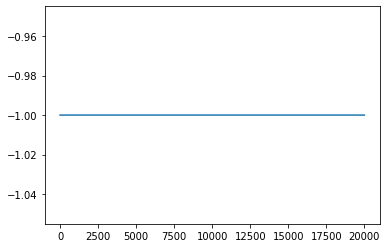

In [44]:
plt.plot(episode_reward_history)
plt.show()

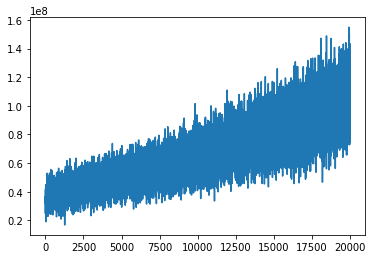

In [45]:
plt.plot(losses)
plt.show()

**Question 11:**
Plotting the average and training loss per 250 games

**Question 12:**
Same, but buffer size of 0

**Question 13:**
Use n_star method vs Opt(0.5)
test vs M_opt and M_rand

**Question 14:**
Using best n_star
do vs Opt(e) for different e
else same

**Question 15:**
what are the highest M_opt and M_rand

## 3.3 DQN self-practise

Different types of E
with M_opt and M_rand

**Question 16:**
Does the agent learn to play tic tac toe?

What is the effect of e?

**Question 17**
Using n_star

Does decreasing e help more than fixed e?

What is the effect of n_star?

**Question 18:**
Higehst values of M_opt and M_rand


**Question 19:**

Visualize heatmap for 3 states

Does it make sense?

Does it learn to play well?